In [73]:
from mobster_mv import mobster_MV
from plot_functions import plot_marginals, plot_deltas, plot_paretos, plot_betas
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component, only_pareto_binomial_component
import numpy as np
import pandas as pd
import pyro.distributions as dist
from BoundedPareto import BoundedPareto
from scipy.stats import pareto, beta, uniform, norm, lognorm



import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [75]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, probs_beta, a_beta, b_beta, weights):
    # return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)
    return torch.log(weights) + dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, probs_pareto, alpha, weights):
    # return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)
    return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        probs_beta = mb.params["probs_beta"][k, dim]
        return log_sum_exp(beta_lk(NV, DP, probs_beta, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, probs_pareto, alpha, weights)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [76]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


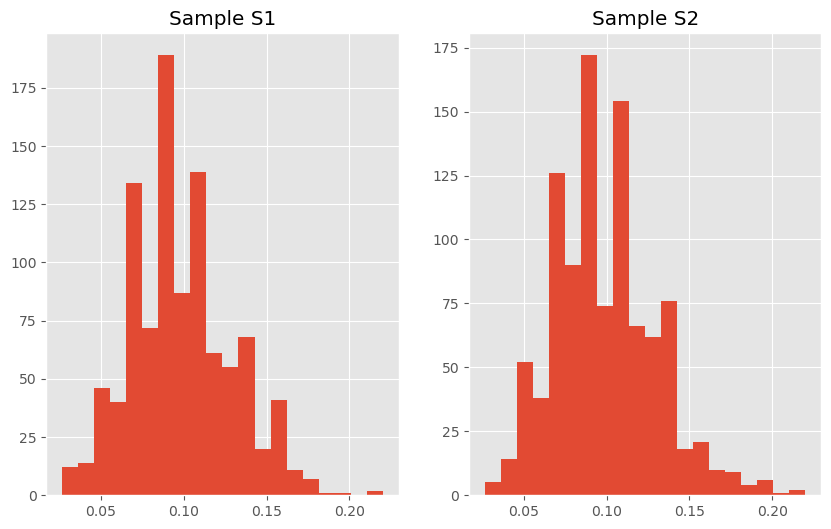

In [77]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [78]:
labels = np.zeros(N1)

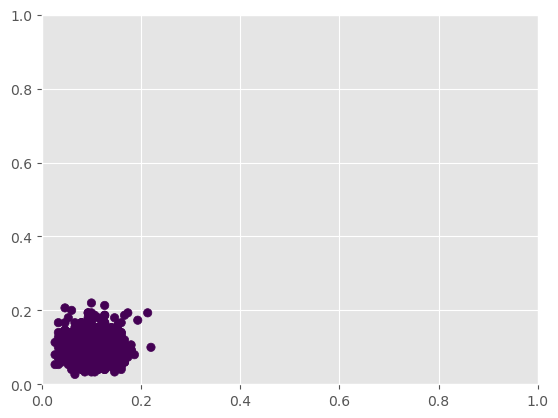

In [79]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0986, 0.0994]])
Beta:  tensor([[0.9388, 0.9362]])
Pareto:  tensor([[-1.5682, -1.5926]])
Alpha:  tensor([[2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9900, 1.9900]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 33205.22265625
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9974, 1.9974]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0994, 0.1002]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0978, 0.0986]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0978, 0.0986]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.0982, 0.9018],
         [0.0982, 0.9018]]], grad_fn=<DivBackward0>)


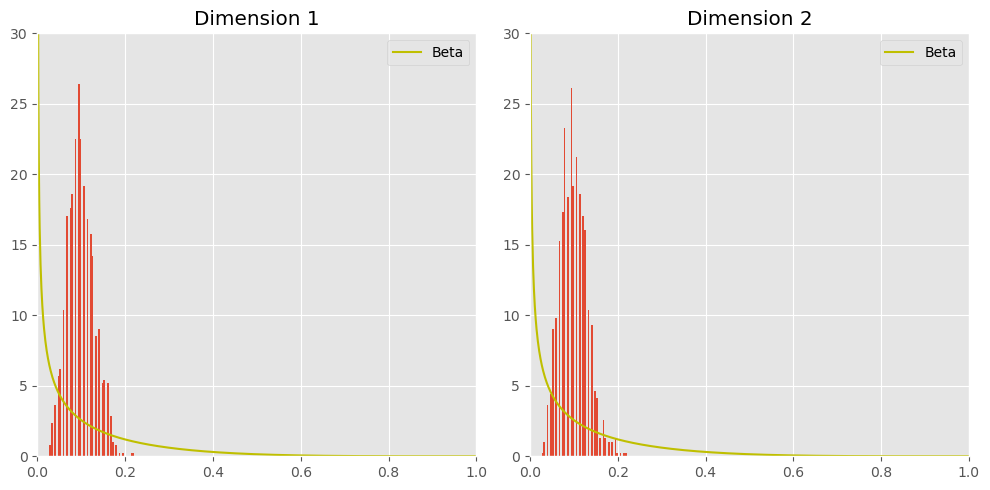

Alpha:  tensor([[1.9974, 1.9974]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0046, 2.0046]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0076, 2.0076]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0066, 2.0066]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0035, 2.0035]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9998, 1.9998]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9965, 1.9965]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9948, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9948, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9963, 1.9963]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9986, 1.9986]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0010]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0029, 2.0029]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0039, 2.0039]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0037, 2.0037]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0025, 2.0025]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0008, 2.0008]], grad_fn=<AddBackward0

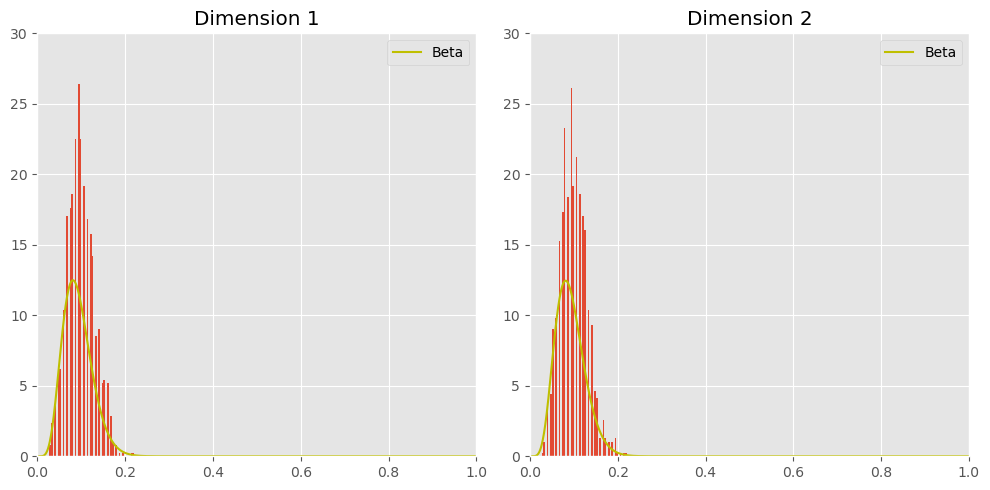

Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0

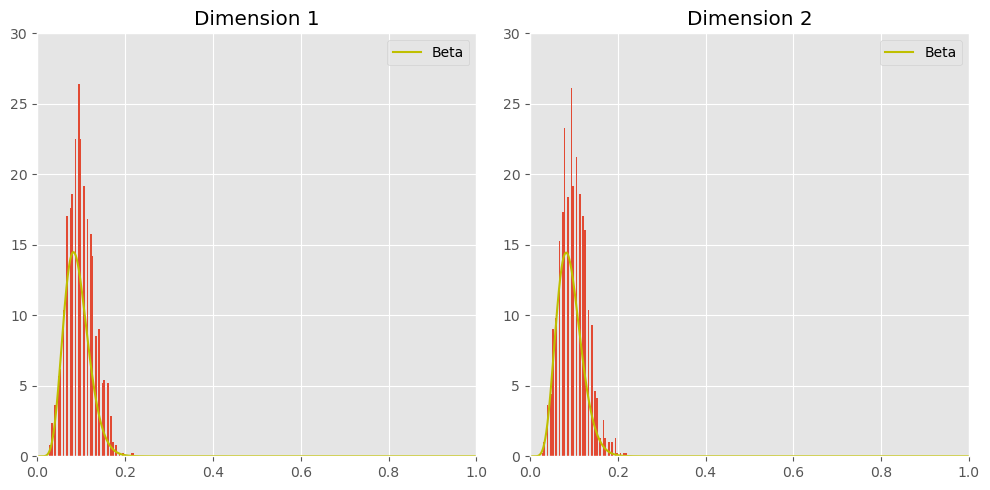

Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha

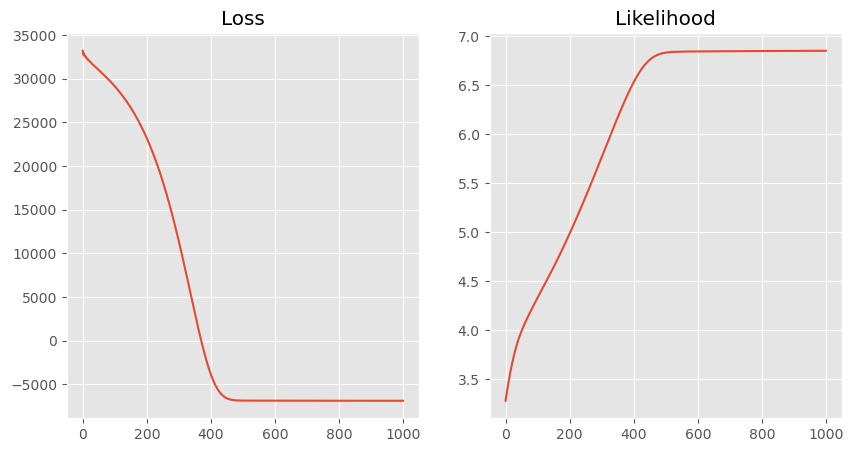

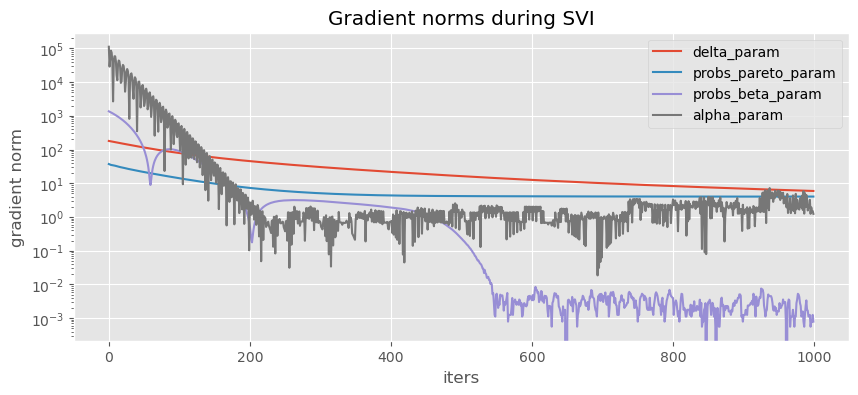

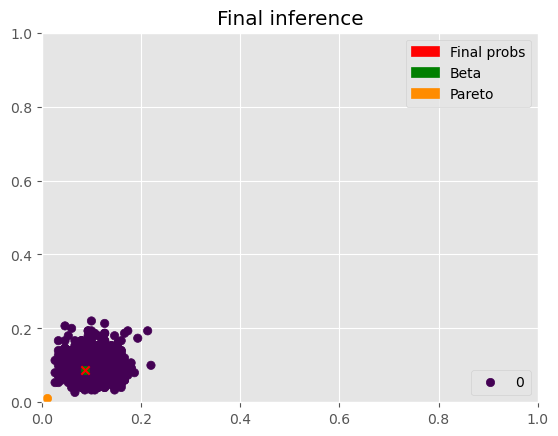

In [80]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 1000, lr = 0.005)

In [81]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(4.0046)
tensor(-0.7185)
tensor(4.0073)
tensor(-1.2030)


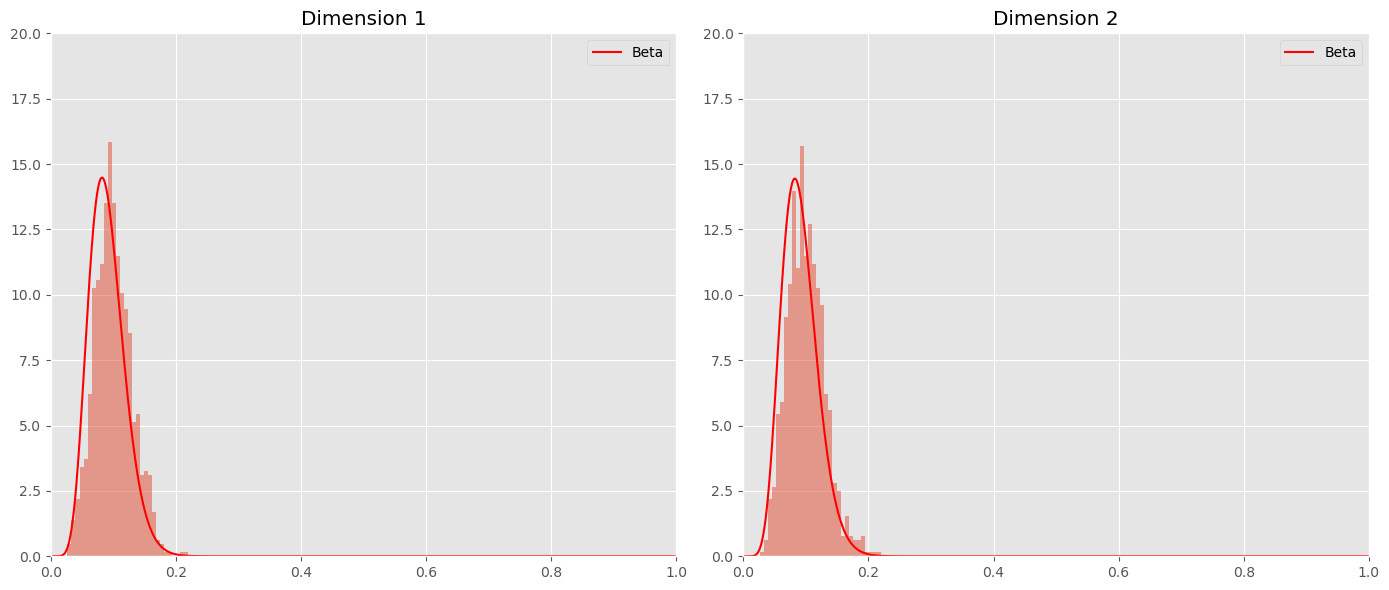

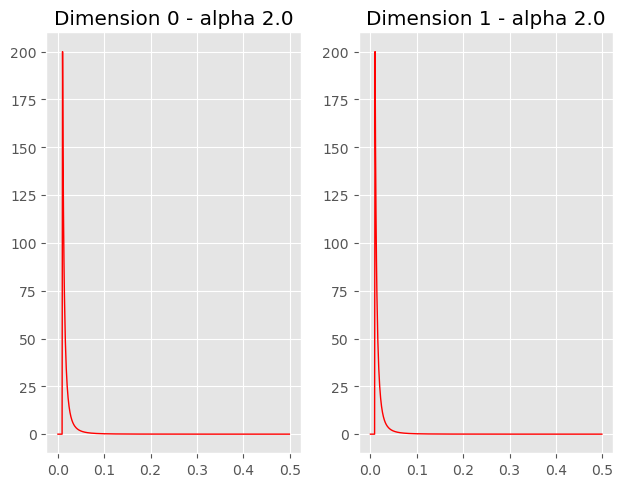

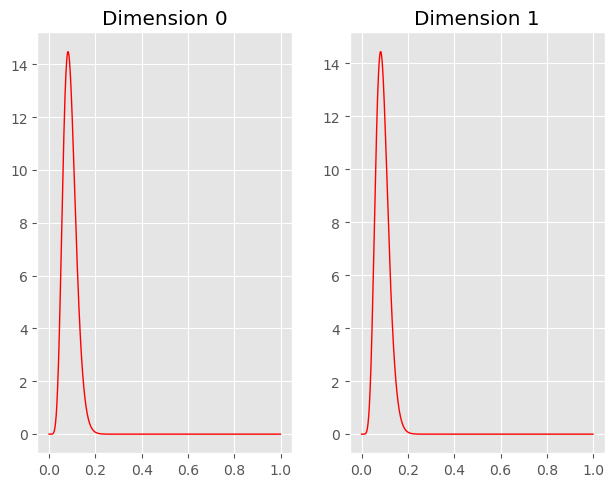

In [82]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [83]:
mb.params

{'probs_beta': tensor([[0.0862, 0.0866]]),
 'probs_pareto': tensor([[0.0112, 0.0117]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.0032, 0.9968],
          [0.0031, 0.9969]]]),
 'alpha_pareto': tensor([[2.0000, 2.0000]]),
 'phi_beta': tensor([[0.0902, 0.0907]]),
 'k_beta': tensor([[101.2327, 101.2328]]),
 'responsib': tensor([[0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.

Ho notato che inizialmente mette la pareto su entrambe le dimensioni, ma aumentando il numero di iterazioni il valore p della beta diminuisce finchè non arriva a 0.1 quindi il delta indica una beta. Aumentando ancora il numero di iterazioni la p però continua a scendere e quindi fitta nuovamente la pareto. BOH

### One pareto-pareto component

In [84]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [85]:
"""
NV = torch.ones([N1, 2]) # component 1
alpha_x=2
L_x=0.01
H_x=0.5
alpha_y=2
L_y=0.01
H_y=0.5
n=100
# x-axis component 1
NV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()
NV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()

DP = torch.ones([N1, 2]) * n
"""

'\nNV = torch.ones([N1, 2]) # component 1\nalpha_x=2\nL_x=0.01\nH_x=0.5\nalpha_y=2\nL_y=0.01\nH_y=0.5\nn=100\n# x-axis component 1\nNV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()\nNV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()\n\nDP = torch.ones([N1, 2]) * n\n'

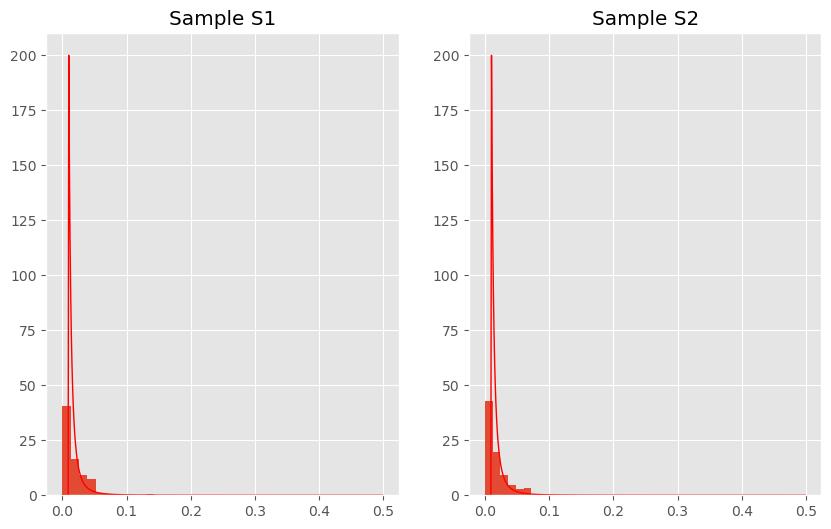

In [86]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

x = np.arange(0, 0.5, 0.001)
pdf = pareto.pdf(x, 2.0, scale=0.01)
axes[0].plot(x, pdf, 'r-', lw=1)

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
axes[1].plot(x, pdf, 'r-', lw=1)
plt.show()

In [87]:
labels = np.zeros(N1)

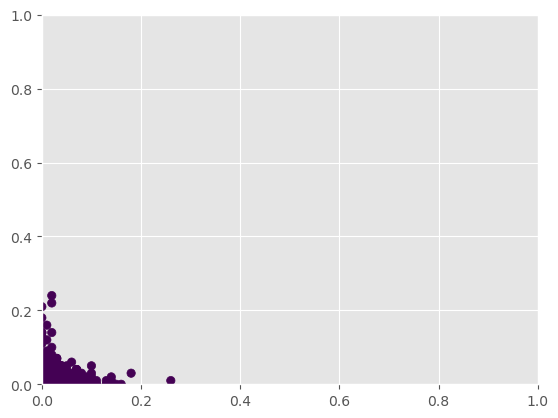

In [88]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.0195]])
Beta:  tensor([[1.3473, 1.3437]])
Pareto:  tensor([[3.3633, 3.3010]])
Alpha:  tensor([[2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 25879.306640625
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9995, 1.9995]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0191, 0.0195]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0100, 5.0100]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.9004, 0.0996],
         [0.9004, 0.0996]]], grad_fn=<DivBackward0>)


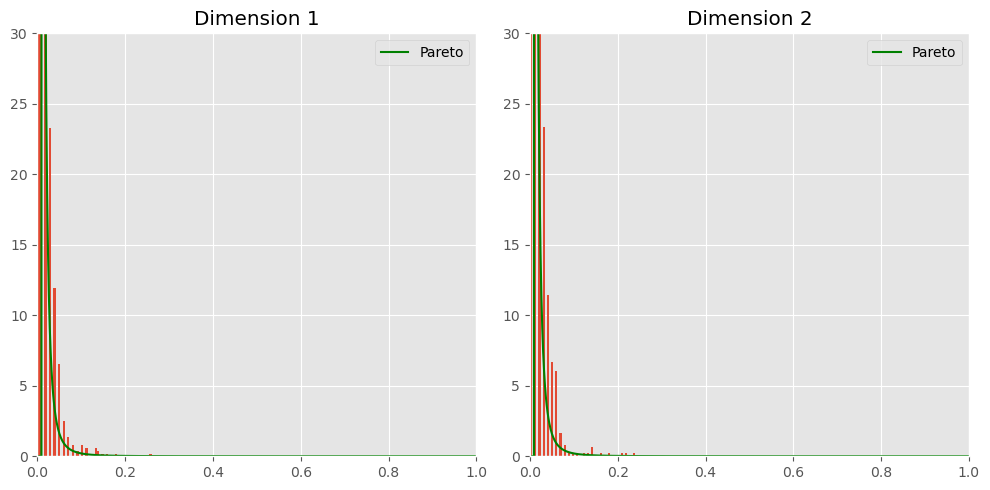

Alpha:  tensor([[1.9995, 1.9995]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0009]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0014]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0013, 2.0012]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0006, 2.0006]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9999, 1.9999]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9993, 1.9993]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9989, 1.9989]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9990, 1.9990]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9993, 1.9993]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9997, 1.9997]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0002, 2.0002]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0006, 2.0006]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0007, 2.0007]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0007, 2.0007]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0004]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0001, 2.0001]], grad_fn=<AddBackward0

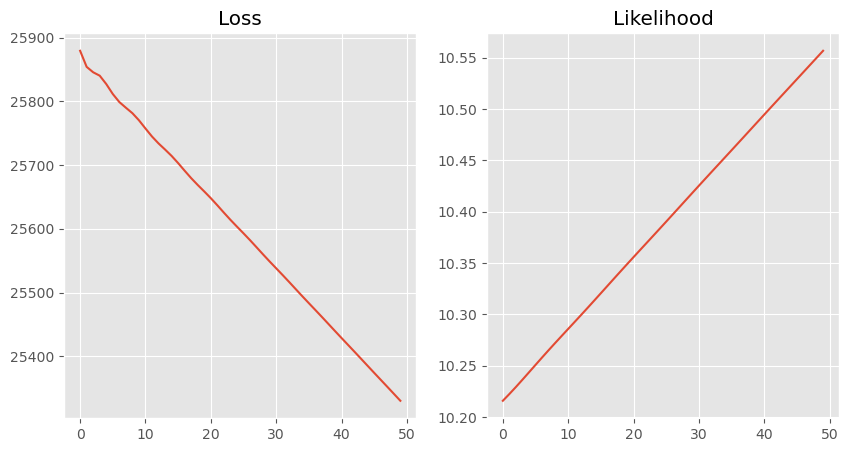

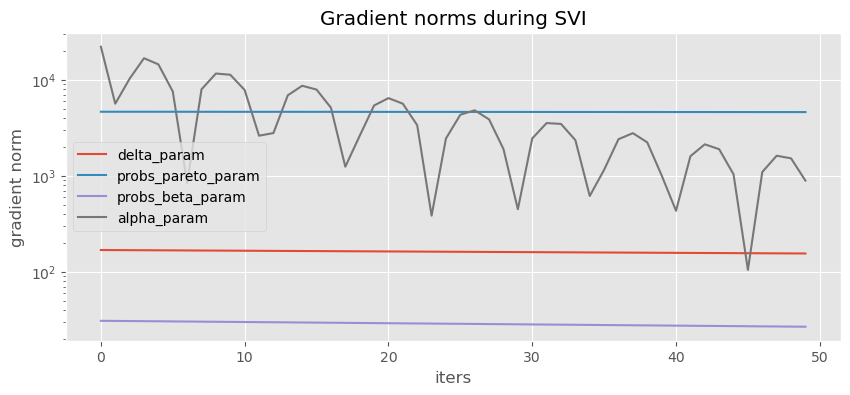

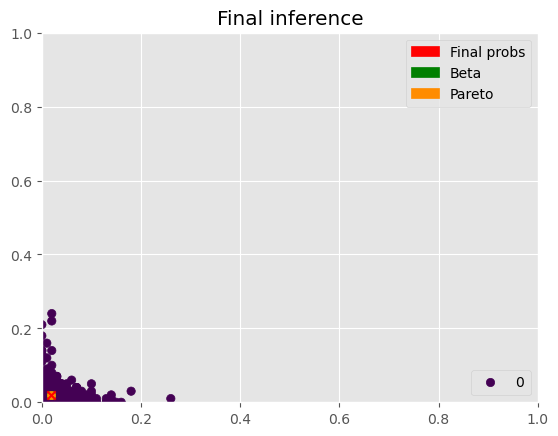

In [89]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [90]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(5.2841)
tensor(5.3416)
tensor(5.2356)
tensor(5.3381)


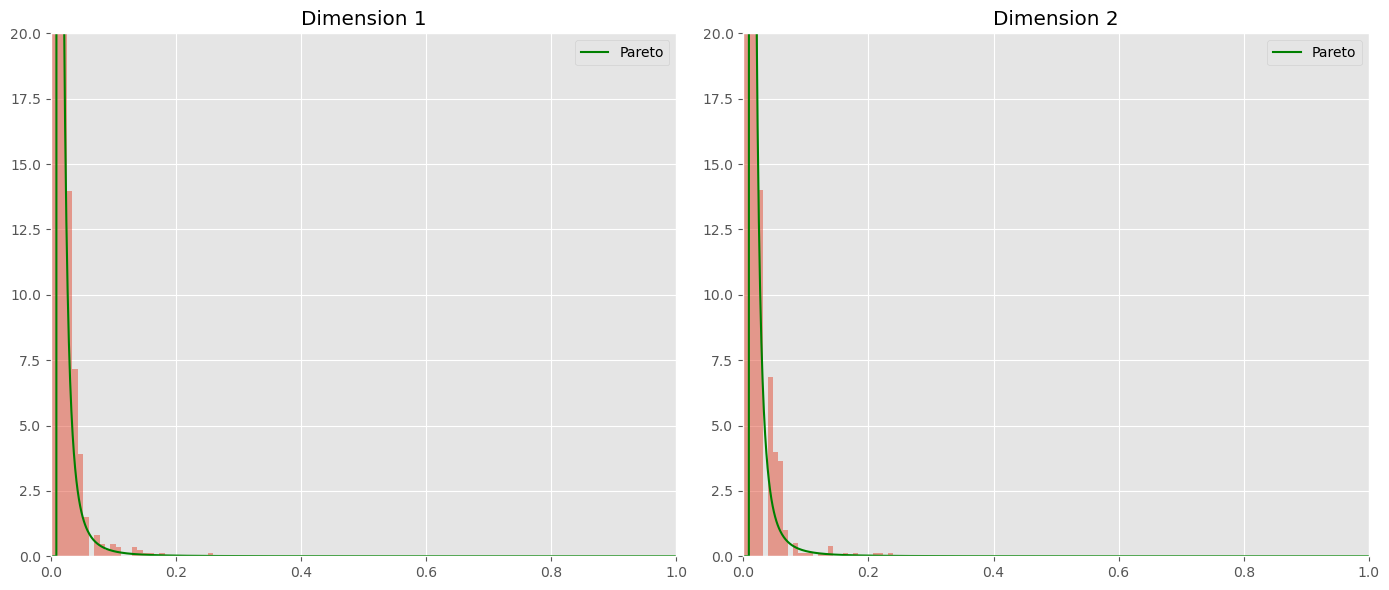

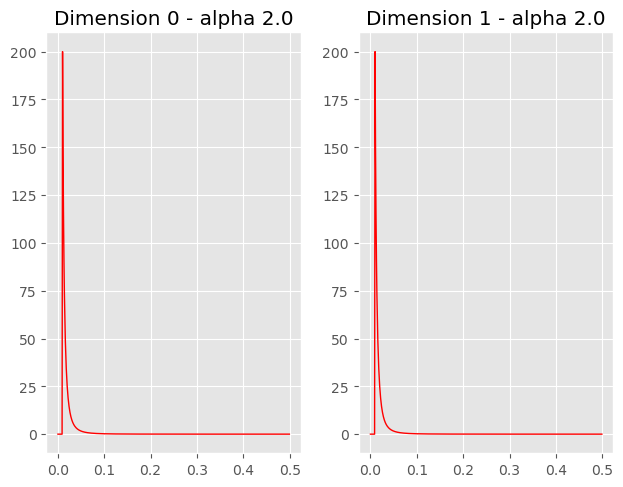

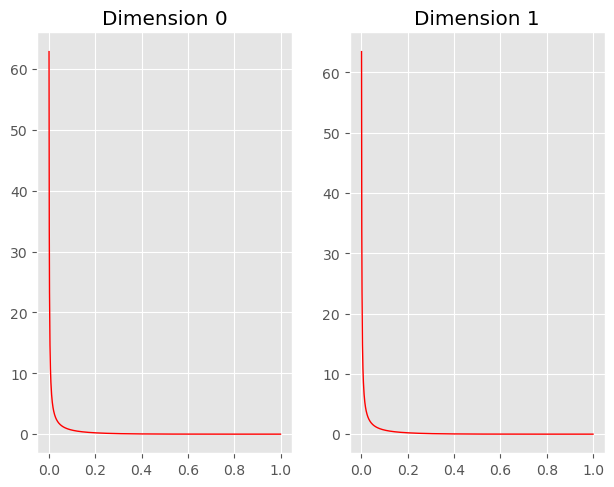

In [91]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [92]:
mb.params

{'probs_beta': tensor([[0.0182, 0.0185]]),
 'probs_pareto': tensor([[0.0181, 0.0185]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9087, 0.0913],
          [0.9087, 0.0913]]]),
 'alpha_pareto': tensor([[2.0000, 2.0000]]),
 'phi_beta': tensor([[0.0200, 0.0204]]),
 'k_beta': tensor([[5.2632, 5.2632]]),
 'responsib': tensor([[0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003

### One beta-pareto component

In [93]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

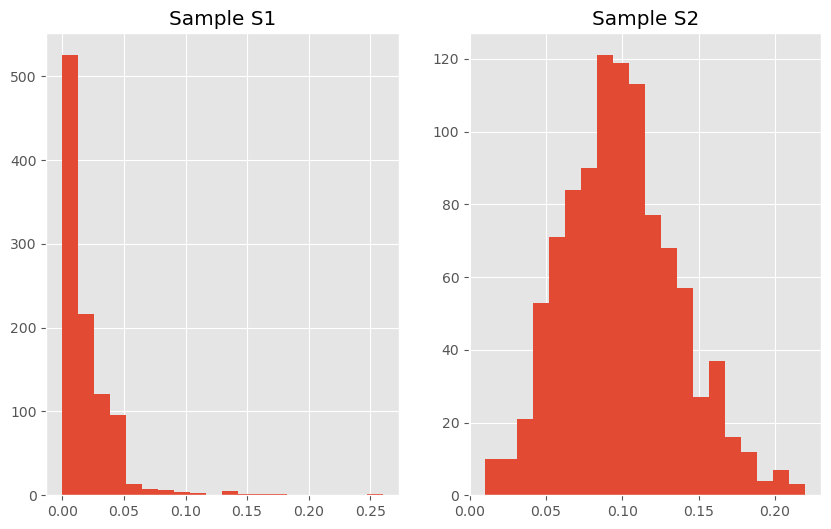

In [94]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [95]:
labels = np.zeros(N1)

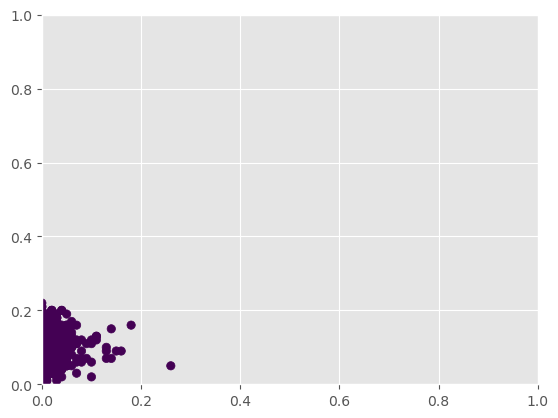

In [96]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.1002]])
Beta:  tensor([[1.3473, 0.9338]])
Pareto:  tensor([[ 3.3633, -1.6163]])
Alpha:  tensor([[2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9900, 1.9900]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 29442.60546875
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9974, 1.9974]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0192, 0.1010]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0189, 0.0994]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0189, 0.0994]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.9018, 0.0982],
         [0.0982, 0.9018]]], grad_fn=<DivBackward0>)


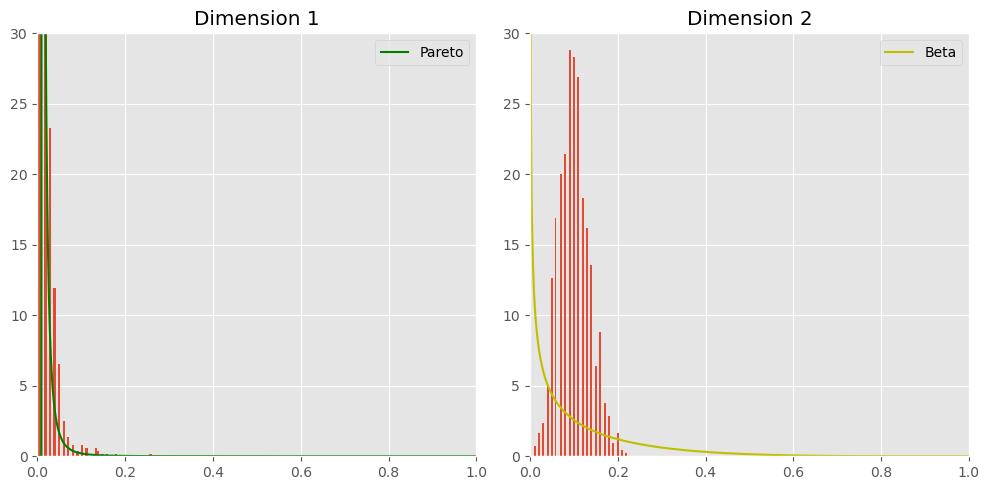

Alpha:  tensor([[1.9974, 1.9974]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0046, 2.0046]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0075, 2.0076]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0065, 2.0066]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0034, 2.0035]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9997, 1.9998]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9965, 1.9965]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9948, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9949, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9963, 1.9963]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9986, 1.9986]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0010]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0029, 2.0029]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0038, 2.0039]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0036, 2.0037]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0025, 2.0025]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0008, 2.0008]], grad_fn=<AddBackward0

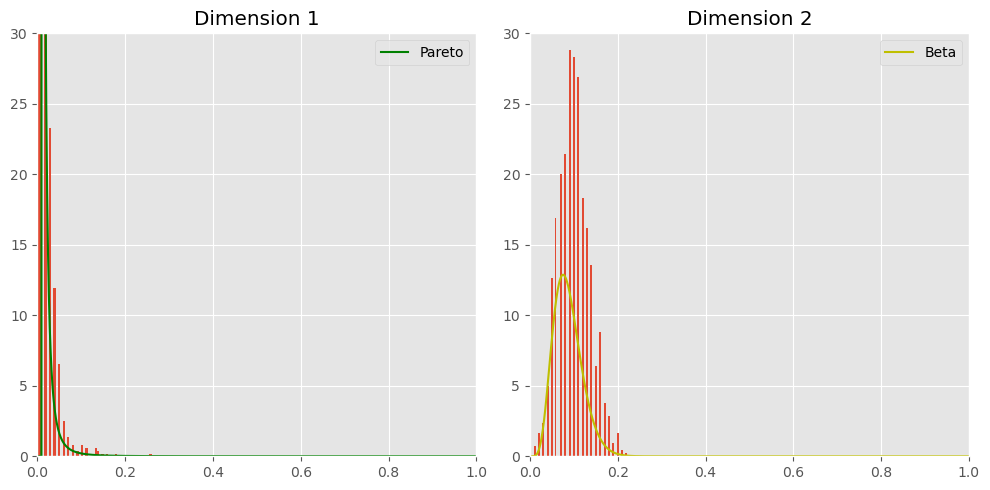

Alpha:  tensor([[2.0004, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0005, 2.0000]], grad_fn=<AddBackward0

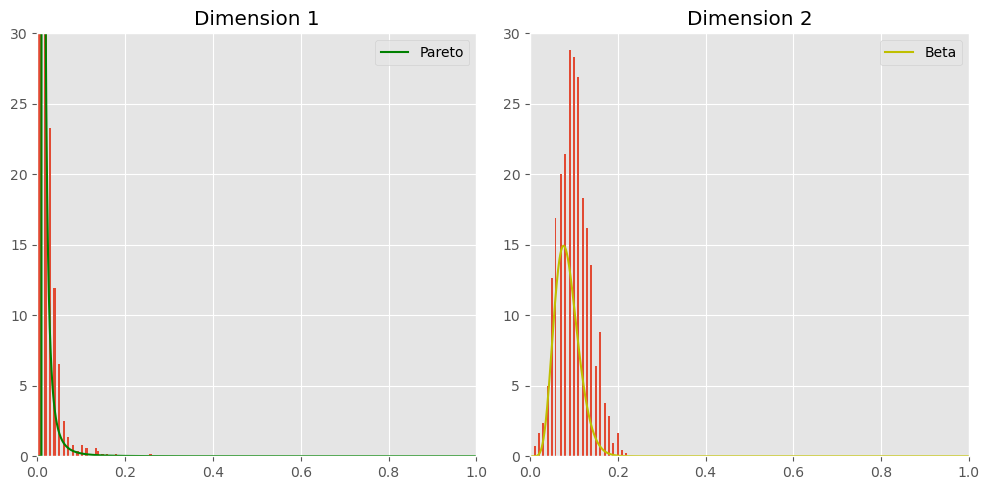

Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0010, 2.0000]], grad_fn=<AddBackward0

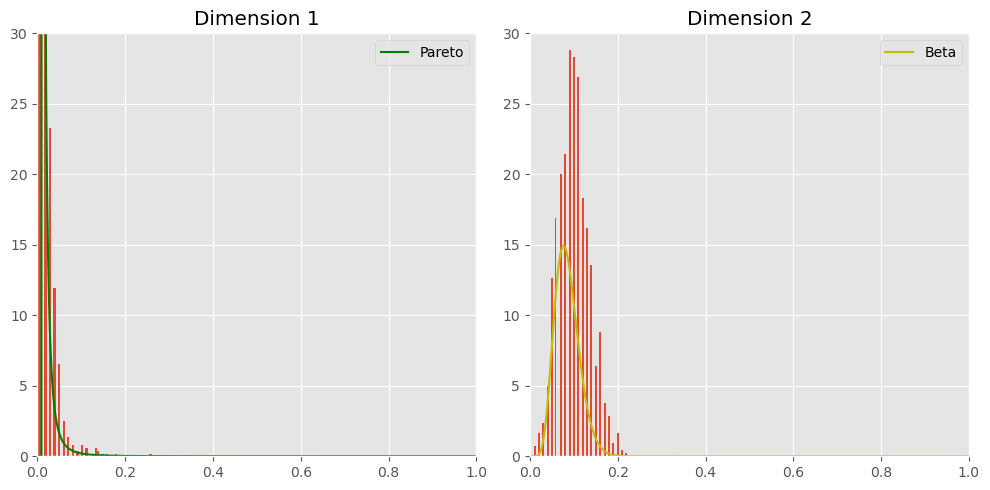

Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0014, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0015, 2.0000]], grad_fn=<AddBackward0

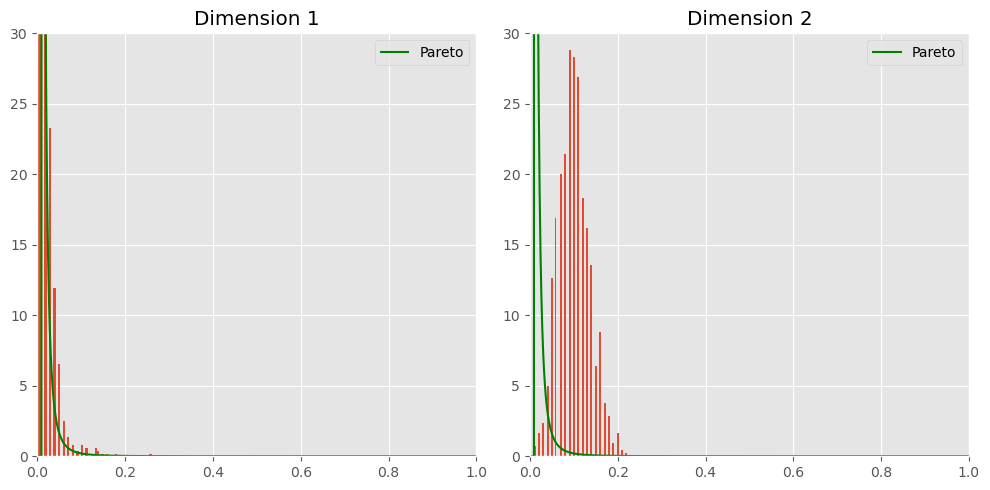

Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0019]], grad_fn=<AddBackward0

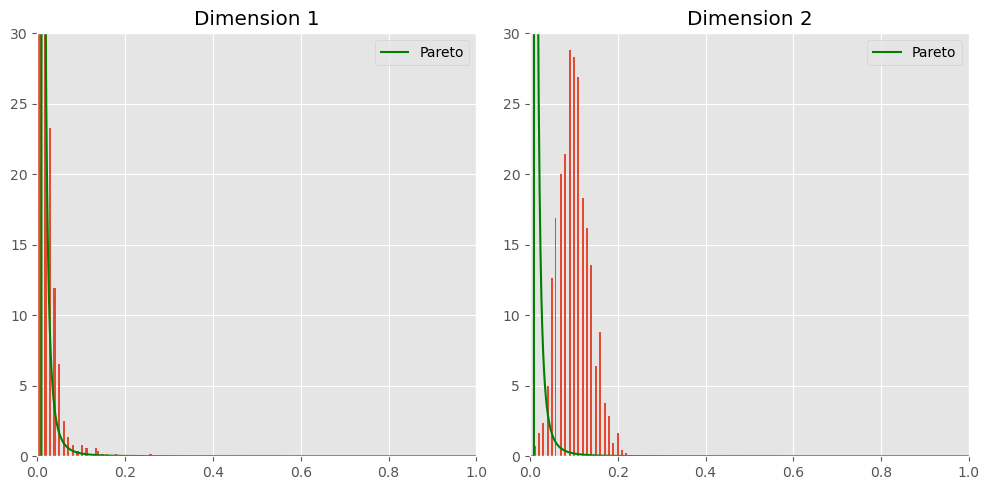

Alpha:  tensor([[2.0028, 2.0029]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0016, 2.0028]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0031, 2.0030]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0016, 2.0027]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0031]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0022, 2.0026]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0021, 2.0032]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0024]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0018, 2.0035]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0020]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0039]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0025, 2.0016]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0023, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0021, 2.0013]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0019, 2.0018]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0026, 2.0033]], grad_fn=<AddBackward0

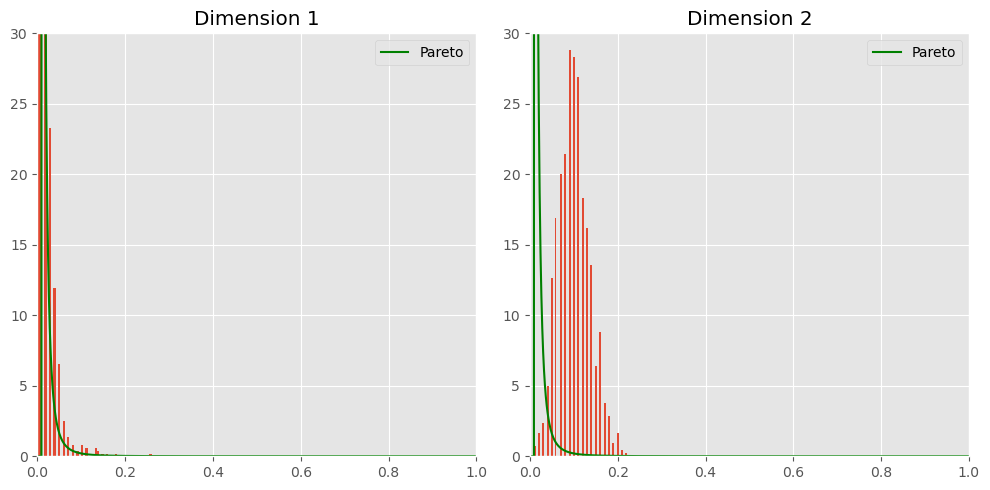

Alpha:  tensor([[2.0029, 2.0040]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0025, 2.0034]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0042]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0032]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0029]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0026, 2.0046]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0027]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0026, 2.0049]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0026]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0048]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0027, 2.0029]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0043]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0026, 2.0035]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0036]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0026, 2.0042]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0028, 2.0031]], grad_fn=<AddBackward0

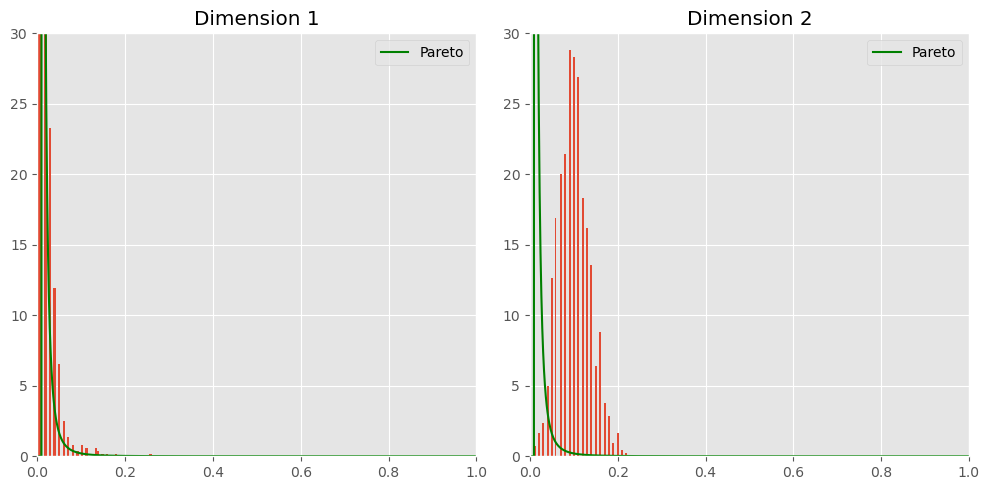

Alpha:  tensor([[2.0033, 2.0043]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0031, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0031, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0032, 2.0044]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0033, 2.0044]], grad_fn=<AddBackward0

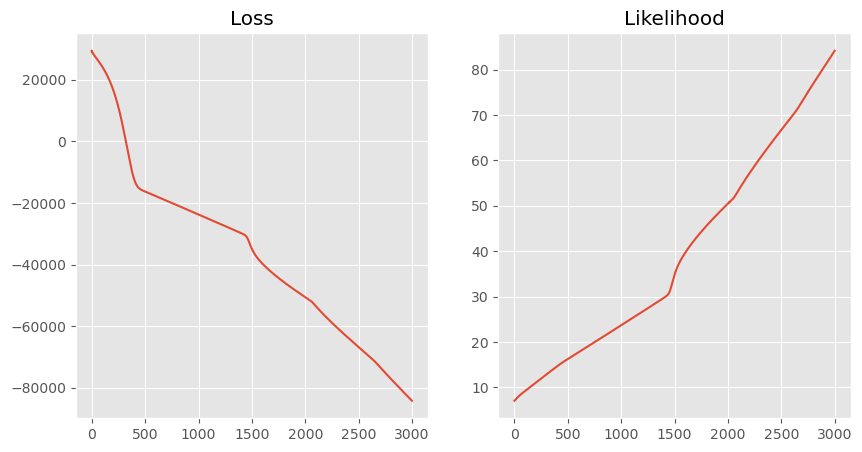

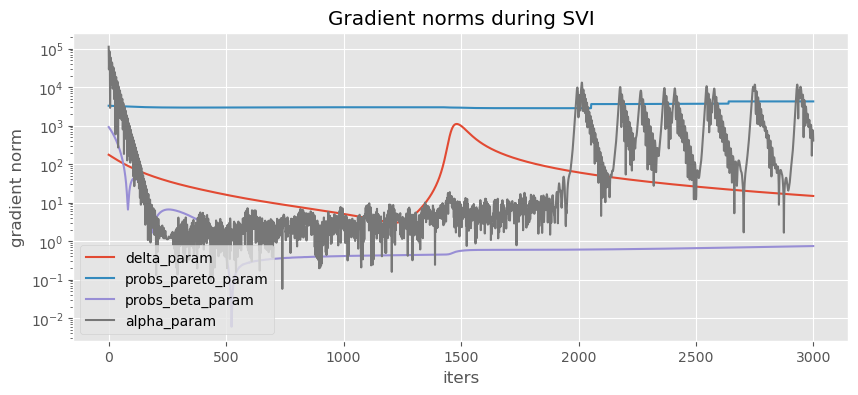

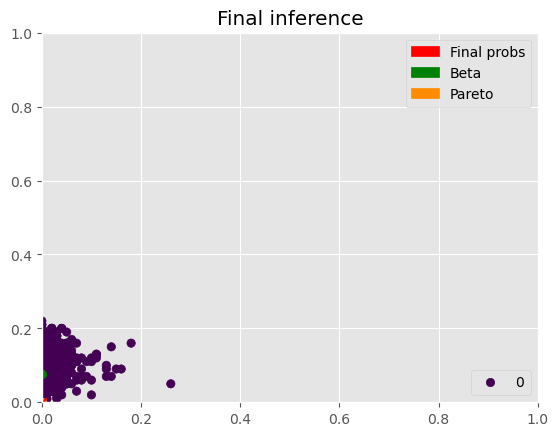

In [97]:
mb = mobster_MV(NV, DP, K = 1, seed = 13)
mb.fit(num_iter = 3000, lr = 0.005)

In [98]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(5.4375)
tensor(5.4117)
tensor(4.2675)
tensor(-10.2386)


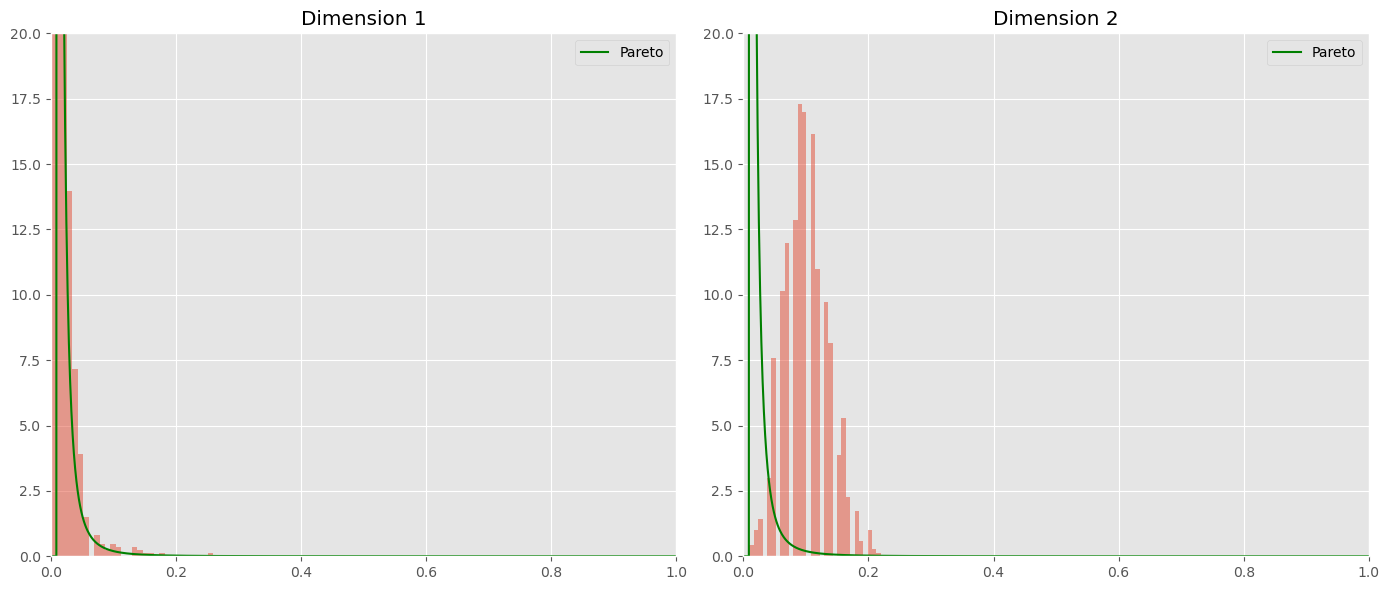

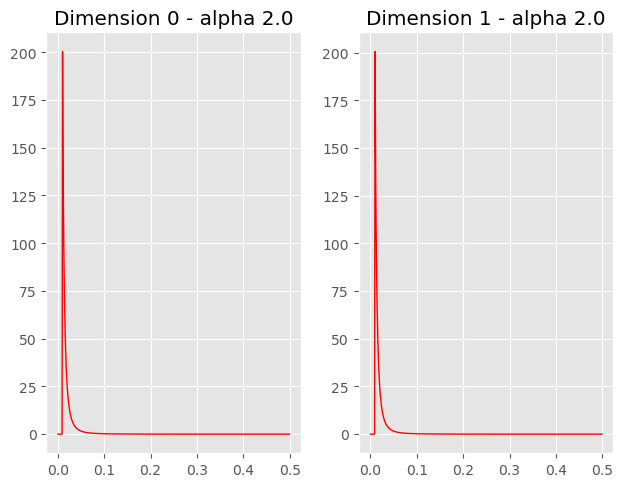

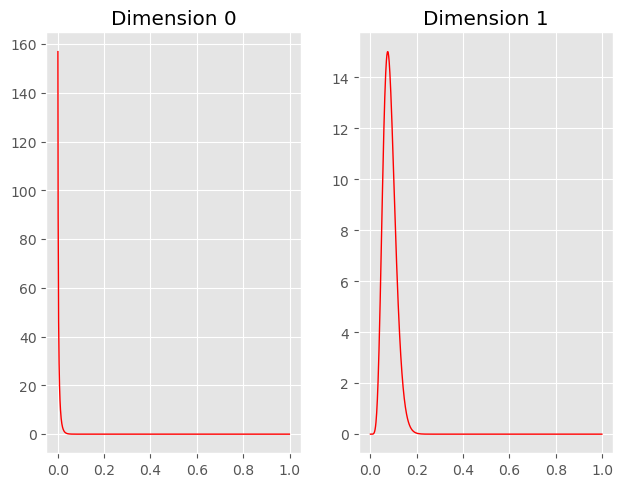

In [99]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [100]:
mb.params

{'probs_beta': tensor([[0.0003, 0.0775]]),
 'probs_pareto': tensor([[1.3624e-08, 1.2113e-10]]),
 'weights': tensor([1.]),
 'delta': tensor([[[9.9960e-01, 4.0278e-04],
          [9.8950e-01, 1.0500e-02]]]),
 'alpha_pareto': tensor([[2.0035, 2.0047]]),
 'phi_beta': tensor([[0.0034, 0.0832]]),
 'k_beta': tensor([[100.0006, 100.0012]]),
 'responsib': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.

### 2 beta-pareto components

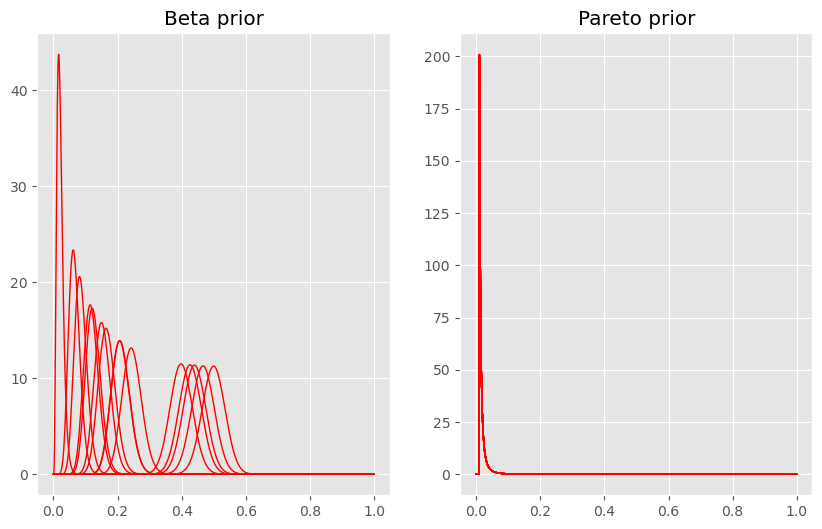

In [101]:
def plot_priors():
    # fig.tight_layout()
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    x = np.arange(0,1,0.001)
    for _ in range(15):
        phi_beta = dist.Uniform(0., 0.51).sample().numpy()
        k_beta = dist.Normal(200, 0.5).sample().numpy()
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        pdf = beta.pdf(x, a_beta, b_beta)
        axes[0].plot(x, pdf, 'r-', lw=1)
        axes[0].set_title("Beta prior")
    # plt.show()
    x = np.arange(0,1,0.001)
    for _ in range(25):
        alpha = dist.Normal(2, 0.005).sample().numpy()
        # alpha_mu = dist.Uniform(0.,1.).sample()
        # alpha = dist.LogNormal(alpha_mu, 0.3).sample().numpy()
        # print(alpha)            
        pdf = pareto.pdf(x, alpha, scale = 0.01)
        axes[1].plot(x, pdf, 'r-', lw=1)
        axes[1].set_title("Pareto prior")
    plt.show()
plot_priors()

In [102]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


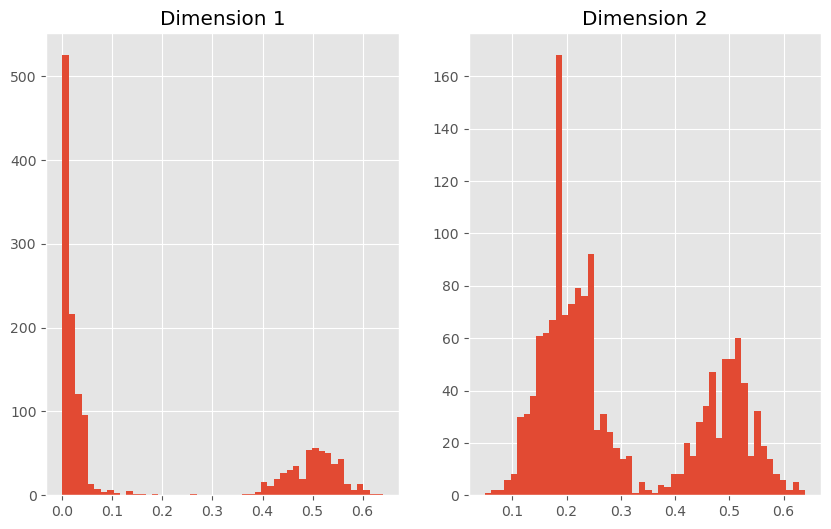

In [103]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [104]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

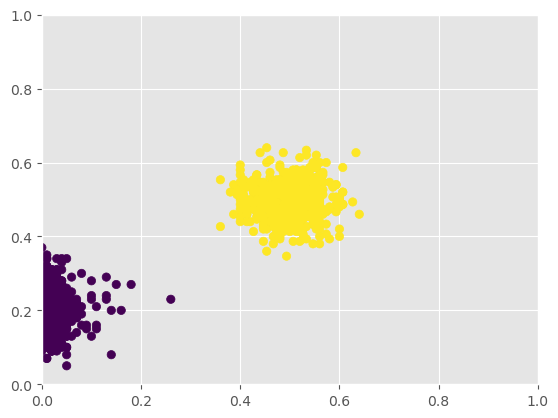

In [105]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

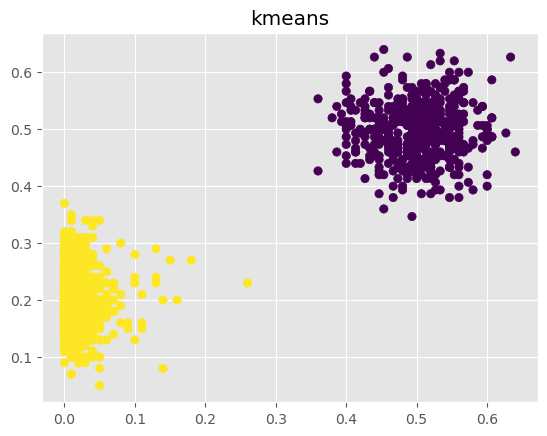

In [106]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.title("kmeans")

kmeans_centers:  tensor([[0.0191, 0.2010],
        [0.5020, 0.4978]])
Beta:  tensor([[1.3473, 0.7153],
        [0.5293, 0.5293]])
Pareto:  tensor([[ 3.3633, -3.7040],
        [-6.4497, -6.4244]])
Alpha:  tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9900, 1.9900],
        [1.9900, 1.9900]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 8254186.5
weights_param tensor([0.8990, 0.1010], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9803, 1.9964],
        [1.9974, 1.9974]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0192, 0.2022],
        [0.5019, 0.4979]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0502, 5.0503],
        [5.0503, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0189, 0.1998],
        [0.5019, 0.4977]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0189, 0.1998],
        [0.5019, 0.4977]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.9018, 0.0982],
         [0.0982, 0.9018]],

        [[0.0982, 0.9018],
 

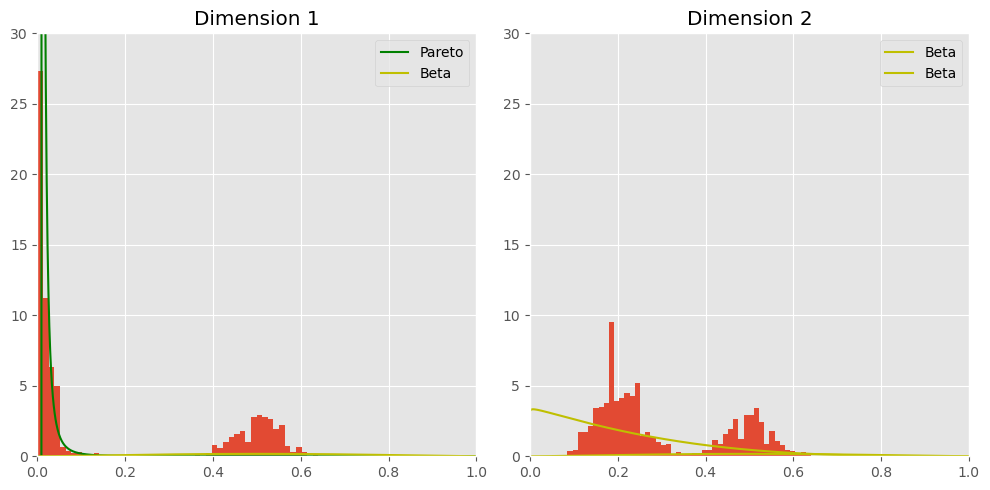

Alpha:  tensor([[1.9803, 1.9964],
        [1.9974, 1.9974]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9709, 2.0028],
        [2.0045, 2.0045]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9622, 2.0053],
        [2.0075, 2.0075]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9545, 2.0040],
        [2.0064, 2.0064]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9483, 2.0009],
        [2.0034, 2.0034]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9438, 1.9974],
        [1.9996, 1.9996]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9412, 1.9949],
        [1.9964, 1.9964]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9404, 1.9941],
        [1.9948, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9412, 1.9951],
        [1.9948, 1.9948]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9433, 1.9971],
        [1.9963, 1.9963]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9465, 1.9994],
        [1.9986, 1.9986]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9505, 2.0014],
        [2.0010, 2.0010]], grad

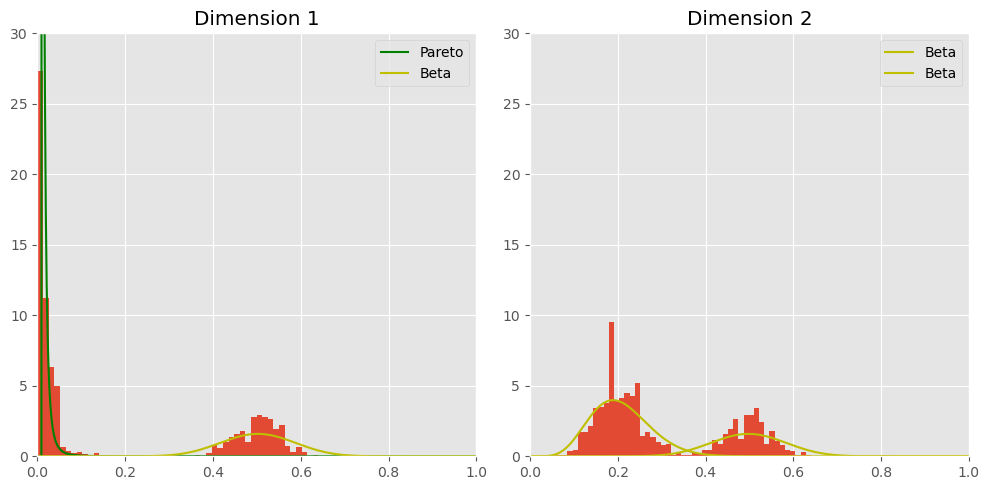

Alpha:  tensor([[2.5742, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5758, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5774, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5790, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5805, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5821, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5837, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5853, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5868, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5884, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5900, 1.9987],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.5916, 1.9987],
        [2.0000, 2.0000]], grad

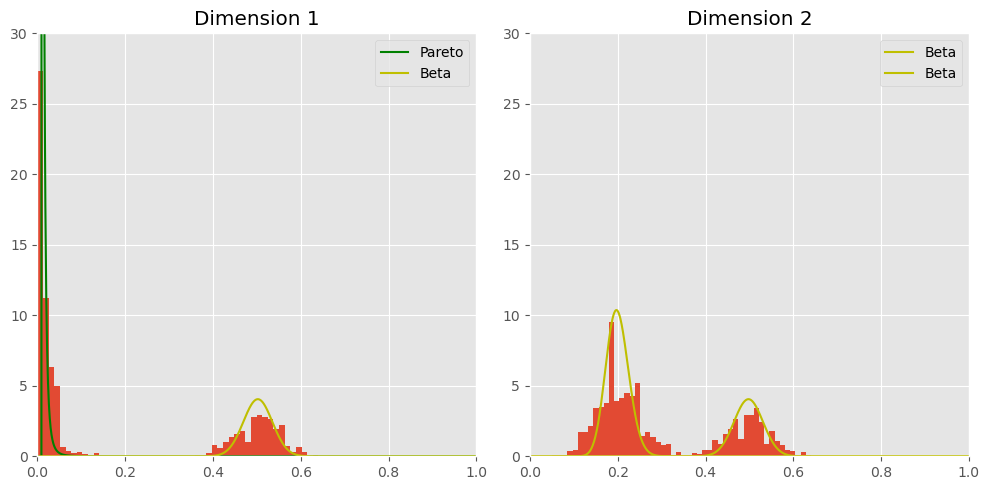

Alpha:  tensor([[3.2635, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2655, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2674, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2694, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2713, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2733, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2752, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2772, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2791, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2811, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2830, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[3.2850, 1.9996],
        [2.0000, 2.0000]], grad

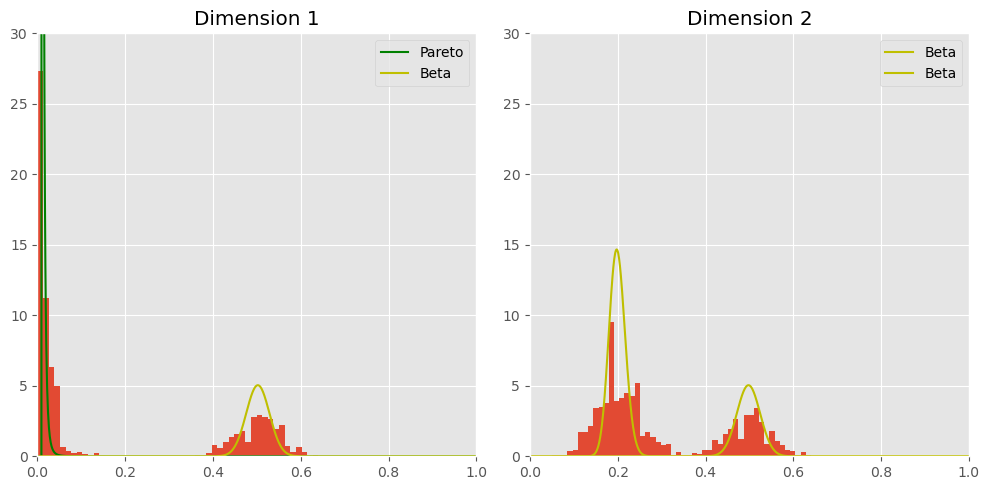

Alpha:  tensor([[4.1081, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1103, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1125, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1147, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1170, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1192, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1214, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1236, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1259, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1281, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1303, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[4.1325, 1.9998],
        [2.0000, 2.0000]], grad

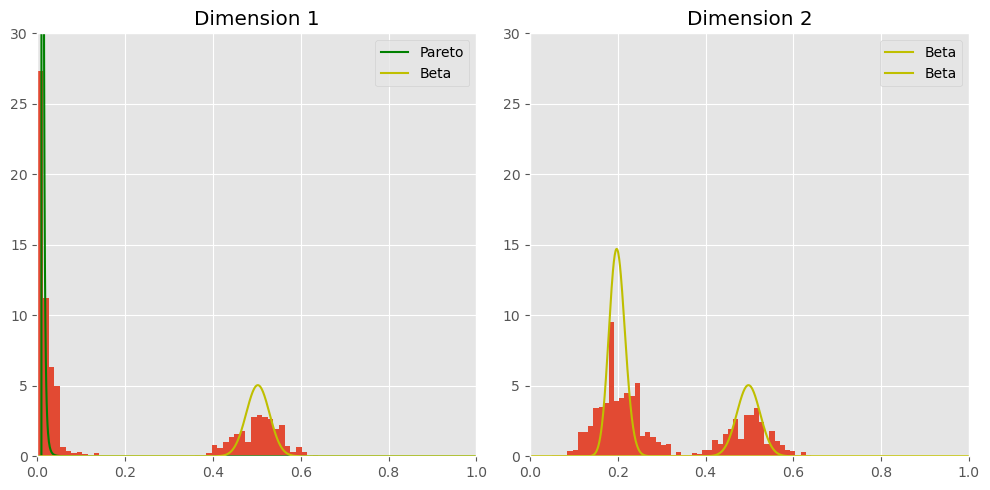

Alpha:  tensor([[5.0605, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0629, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0653, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0677, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0701, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0725, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0749, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0773, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0797, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0821, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0845, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[5.0869, 1.9999],
        [2.0000, 2.0000]], grad

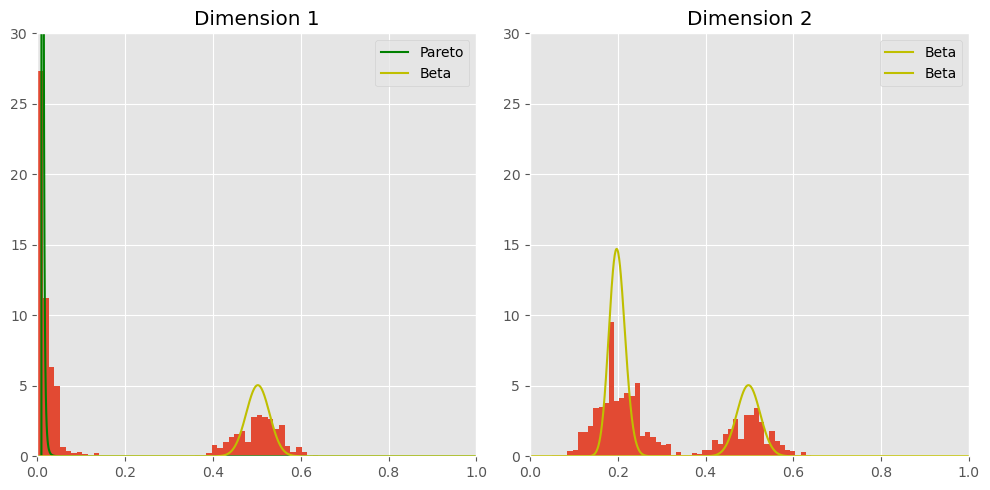

Alpha:  tensor([[6.0444, 1.9999],
        [2.0001, 2.0004]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0473, 1.9999],
        [1.9997, 1.9998]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0559, 1.9998],
        [2.0004, 1.9999]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0500, 2.0000],
        [1.9995, 2.0004]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0580, 1.9998],
        [2.0004, 1.9995]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0611, 1.9999],
        [1.9997, 2.0005]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0579, 1.9999],
        [2.0001, 1.9996]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0671, 1.9999],
        [2.0000, 2.0002]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0664, 1.9999],
        [1.9998, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0669, 1.9998],
        [2.0003, 1.9998]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0747, 1.9999],
        [1.9997, 2.0003]], grad_fn=<AddBackward0>)
Alpha:  tensor([[6.0724, 1.9999],
        [2.0003, 1.9996]], grad

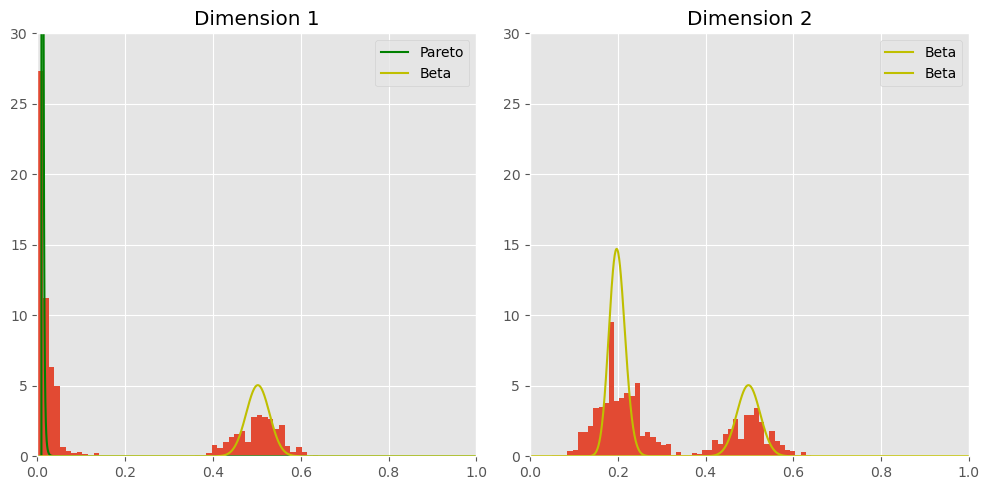

Alpha:  tensor([[7.2042, 1.9997],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2070, 2.0002],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2098, 1.9996],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2126, 2.0001],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2154, 1.9998],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2182, 1.9999],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2210, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2238, 1.9997],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2266, 2.0001],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2294, 1.9997],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2322, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[7.2351, 1.9999],
        [2.0000, 2.0000]], grad

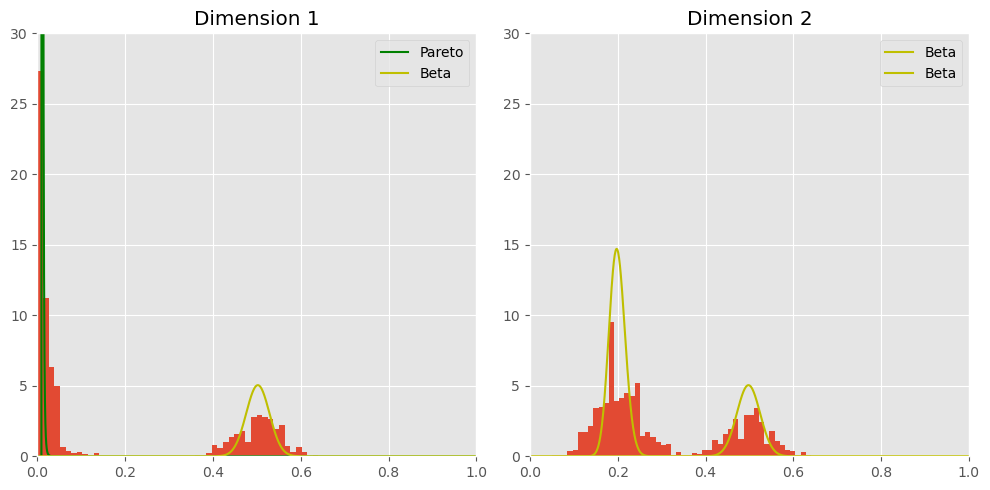

Alpha:  tensor([[8.2906, 1.9995],
        [1.9999, 2.0003]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.2929, 2.0005],
        [2.0002, 1.9997]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.2956, 1.9994],
        [1.9998, 2.0004]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.2983, 2.0003],
        [2.0002, 1.9995]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3007, 1.9998],
        [1.9997, 2.0006]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3036, 1.9998],
        [2.0003, 1.9993]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3060, 2.0002],
        [1.9996, 2.0008]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3087, 1.9995],
        [2.0005, 1.9991]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3114, 2.0003],
        [1.9995, 2.0009]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3140, 1.9996],
        [2.0006, 1.9990]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3168, 2.0001],
        [1.9992, 2.0010]], grad_fn=<AddBackward0>)
Alpha:  tensor([[8.3193, 2.0000],
        [2.0009, 1.9991]], grad

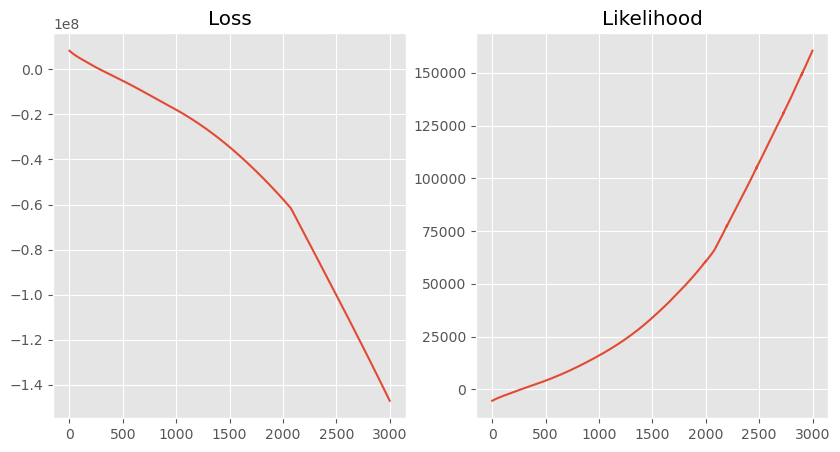

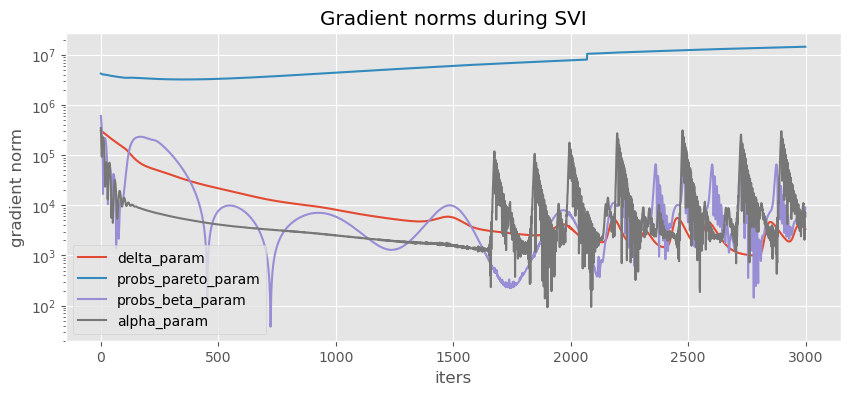

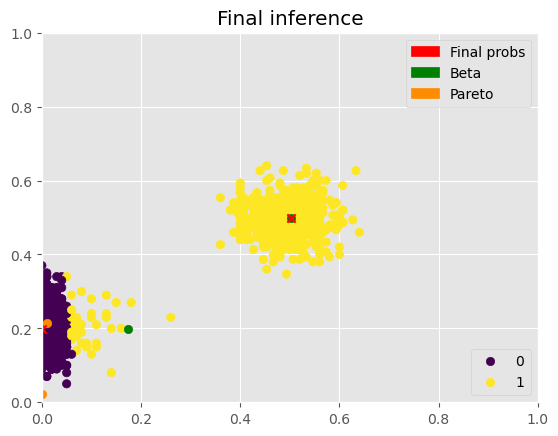

In [107]:
mb = mobster_MV(NV, DP, K = 2, seed = 12)
mb.fit(num_iter = 3000, lr = 0.005)

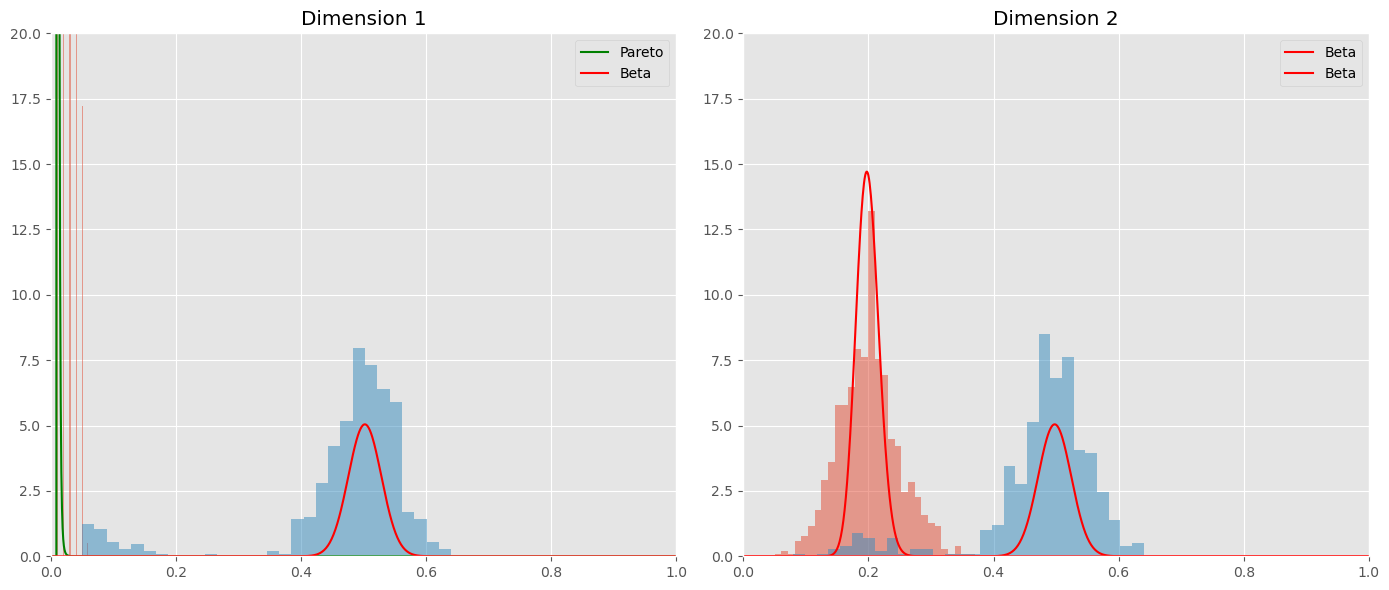

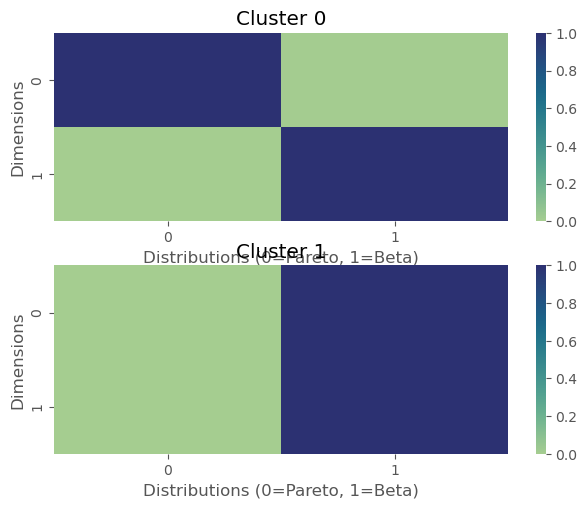

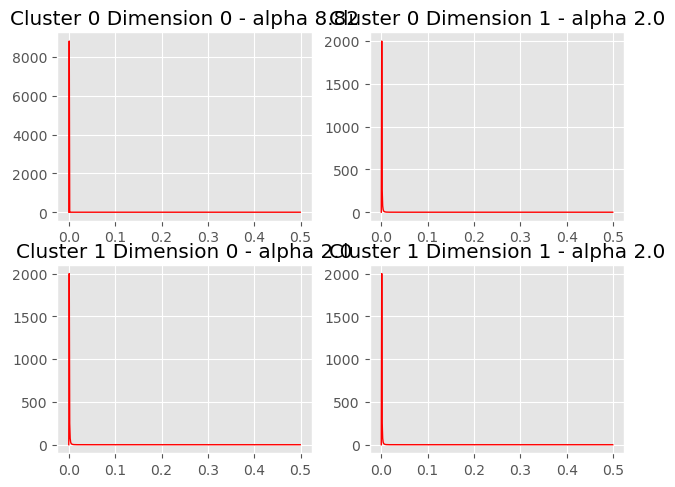

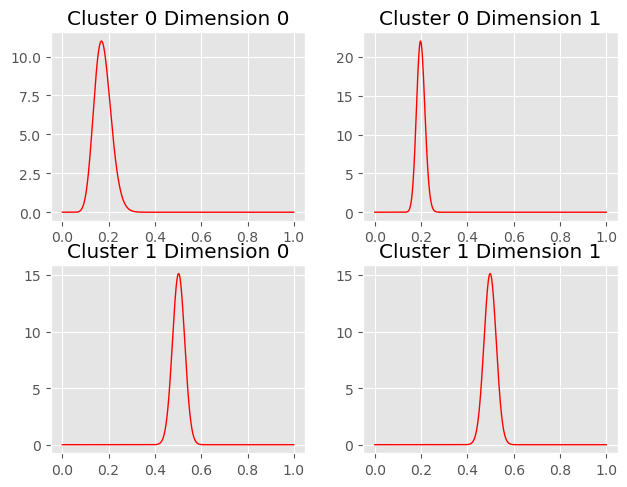

In [108]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [109]:
mb.params

{'probs_beta': tensor([[0.1730, 0.1981],
         [0.5020, 0.4978]]),
 'probs_pareto': tensor([[1.3233e-10, 2.1831e-02],
         [9.6408e-03, 2.1575e-01]]),
 'weights': tensor([0.6667, 0.3333]),
 'delta': tensor([[[9.9448e-01, 5.5250e-03],
          [9.2604e-04, 9.9907e-01]],
 
         [[4.5296e-04, 9.9955e-01],
          [4.5312e-04, 9.9955e-01]]]),
 'alpha_pareto': tensor([[8.8177, 1.9995],
         [1.9999, 2.0001]]),
 'phi_beta': tensor([[0.1751, 0.1987],
         [0.5020, 0.4978]]),
 'k_beta': tensor([[107.6700, 485.8439],
         [360.4578, 360.4496]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.4725e-38, 2.4539e-35, 2.7176e-23,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00]]),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

### 4 beta-pareto components

In [110]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
N5 = 200
seed = 123
# Component 1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

# Component 5
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n5=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n5, N=N5, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


torch.Size([1200, 2])
torch.Size([1200, 2])


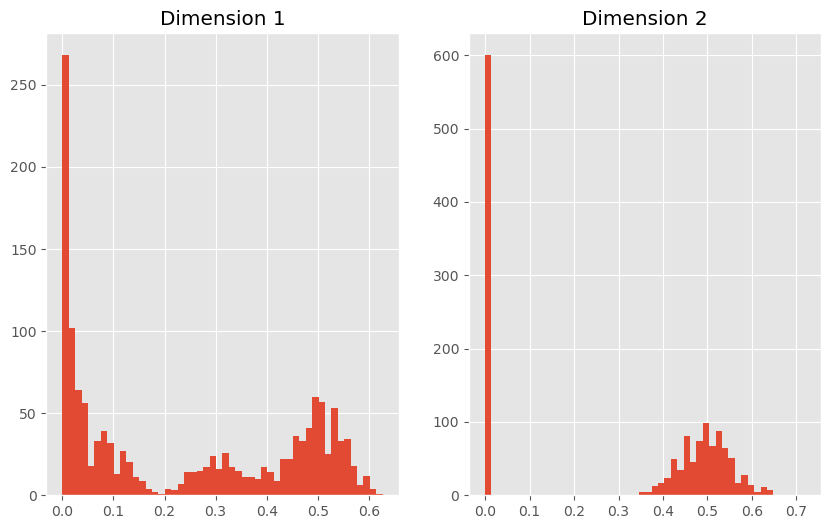

In [111]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [112]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N3)*4
labels = np.concatenate((labels, labels_5))

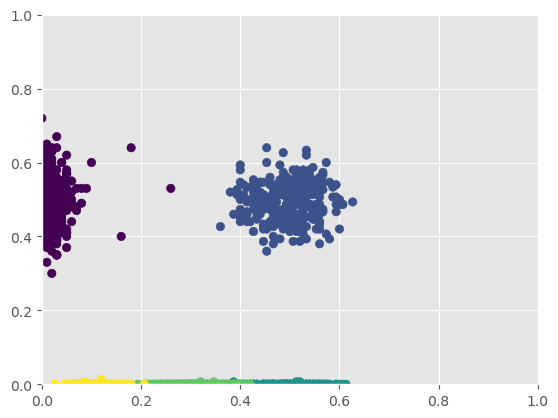

In [113]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8765e-05]])
inertia:  4.6338300704956055


(0.0, 1.0)

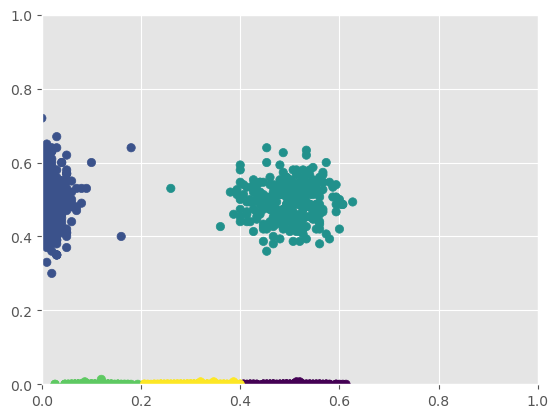

In [114]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[1.0017e-01, 9.9927e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [5.0059e-01, 6.8814e-05],
        [3.0538e-01, 9.6411e-05]])
inertia:  4.6314496994018555


(0.0, 1.0)

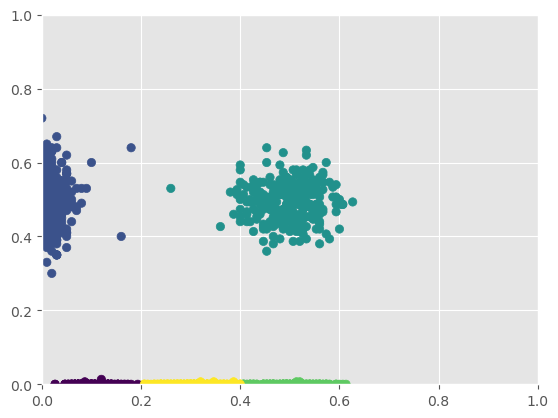

In [115]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=45, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8795e-05]])
Beta:  tensor([[0.5293, 1.6066],
        [1.3564, 0.5293],
        [0.5293, 0.5293],
        [0.9340, 1.6055],
        [0.6018, 1.6055]])
Pareto:  tensor([[-6.4260, 20.3128],
        [ 3.5223, -6.4206],
        [-6.4272, -6.4076],
        [-1.6144, 19.1160],
        [-4.9355, 19.1502]])
Alpha:  tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9900, 2.0100],
        [1.9900, 1.9900],
        [1.9900, 1.9900],
        [1.9900, 2.0100],
        [1.9900, 2.0100]], grad_fn=<AddBackward0>)
Iteration 0: Loss = -6722366.5
weights_param tensor([0.1769, 0.2397, 0.0278, 0.2602, 0.2953], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9974, 2.0201],
        [1.9816, 1.9974],
        [1.9974, 1.9974],
        [1.9966, 2.0201],
    

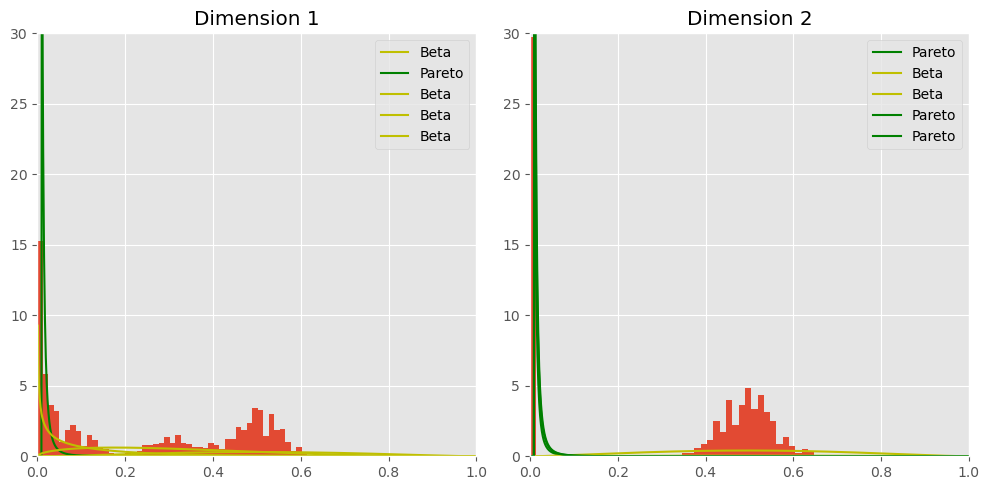

Alpha:  tensor([[1.9974, 2.0201],
        [1.9816, 1.9974],
        [1.9974, 1.9974],
        [1.9966, 2.0201],
        [1.9974, 2.0201]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0046, 2.0302],
        [1.9772, 2.0045],
        [2.0046, 2.0046],
        [2.0031, 2.0302],
        [2.0045, 2.0302]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0075, 2.0404],
        [1.9770, 2.0075],
        [2.0075, 2.0075],
        [2.0056, 2.0403],
        [2.0074, 2.0403]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0065, 2.0505],
        [1.9796, 2.0065],
        [2.0065, 2.0065],
        [2.0044, 2.0505],
        [2.0064, 2.0505]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0035, 2.0607],
        [1.9836, 2.0034],
        [2.0034, 2.0034],
        [2.0012, 2.0607],
        [2.0033, 2.0607]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9997, 2.0710],
        [1.9882, 1.9996],
        [1.9997, 1.9997],
        [1.9977, 2.0709],
        [1.9996, 2.0709]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.996

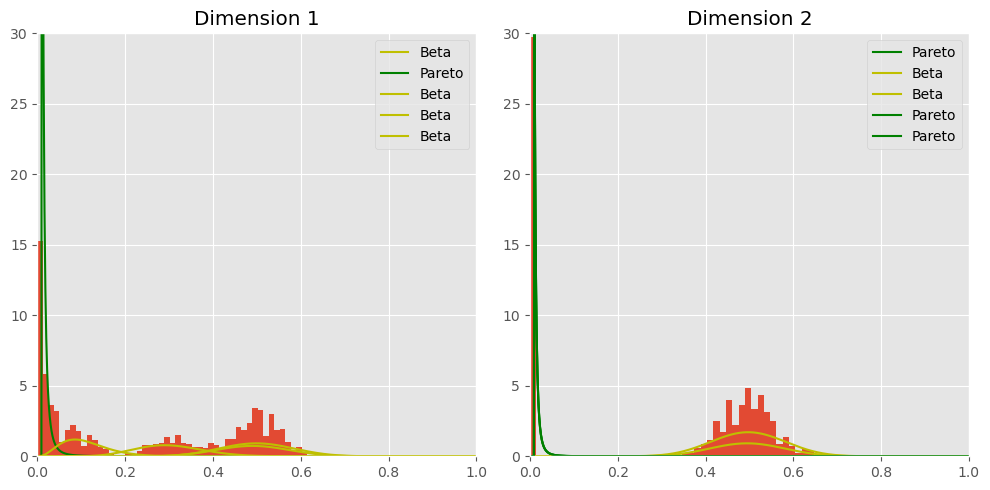

Alpha:  tensor([[2.0000, 2.5529],
        [2.2754, 2.0000],
        [1.9994, 2.0000],
        [1.9999, 2.4896],
        [2.0000, 2.4654]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.5534],
        [2.2761, 2.0000],
        [1.9994, 2.0000],
        [1.9999, 2.4899],
        [2.0000, 2.4656]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.5539],
        [2.2767, 2.0000],
        [1.9994, 2.0000],
        [1.9999, 2.4903],
        [2.0000, 2.4658]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.5544],
        [2.2774, 2.0000],
        [1.9993, 2.0000],
        [1.9999, 2.4906],
        [2.0000, 2.4660]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.5549],
        [2.2781, 2.0000],
        [1.9993, 2.0000],
        [1.9999, 2.4910],
        [2.0000, 2.4662]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0000, 2.5554],
        [2.2788, 2.0000],
        [1.9993, 2.0000],
        [1.9999, 2.4913],
        [2.0000, 2.4664]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.000

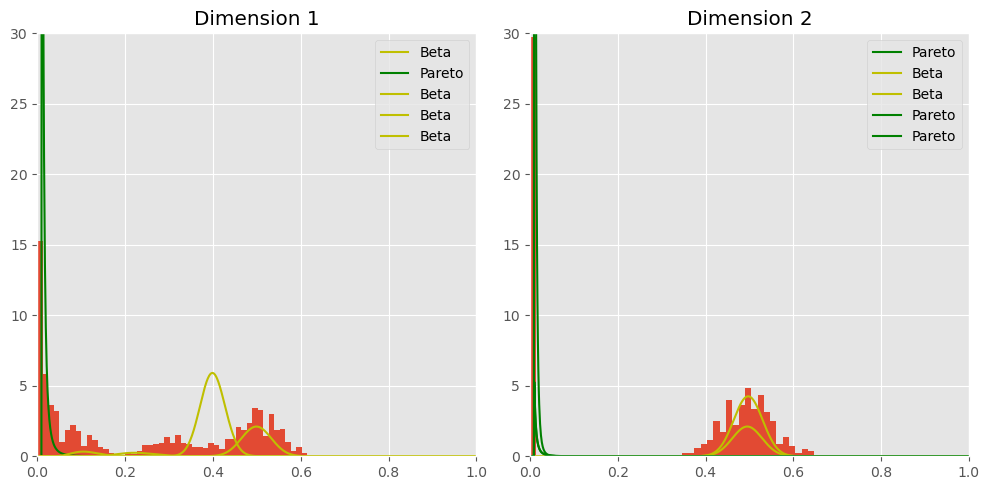

Alpha:  tensor([[1.8894, 4.2112],
        [2.5570, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8894, 4.2130],
        [2.5578, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8894, 4.2148],
        [2.5585, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8894, 4.2166],
        [2.5593, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8894, 4.2185],
        [2.5601, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8894, 4.2203],
        [2.5608, 2.0000],
        [1.9995, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.889

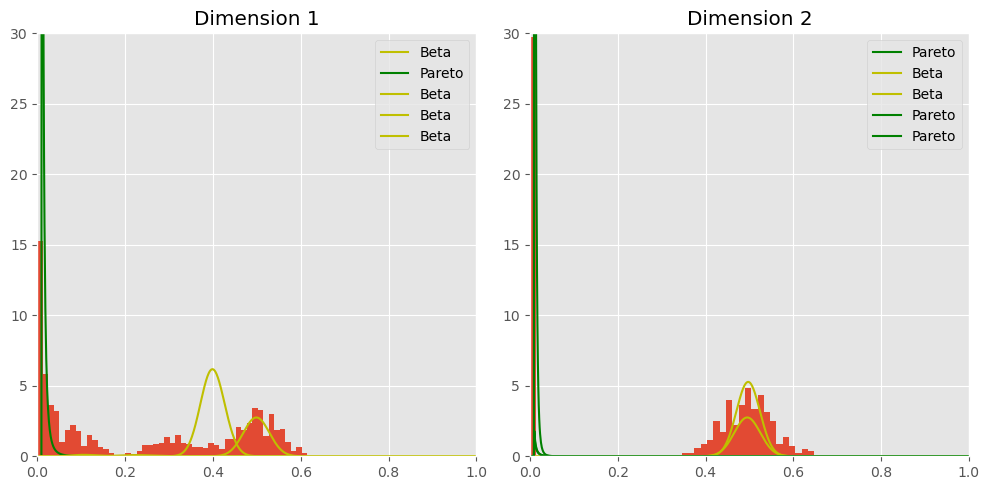

Alpha:  tensor([[1.8893, 4.8261],
        [2.8860, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 4.8275],
        [2.8869, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 4.8289],
        [2.8878, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 4.8302],
        [2.8887, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 4.8316],
        [2.8895, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 4.8330],
        [2.8904, 2.0000],
        [1.9997, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.889

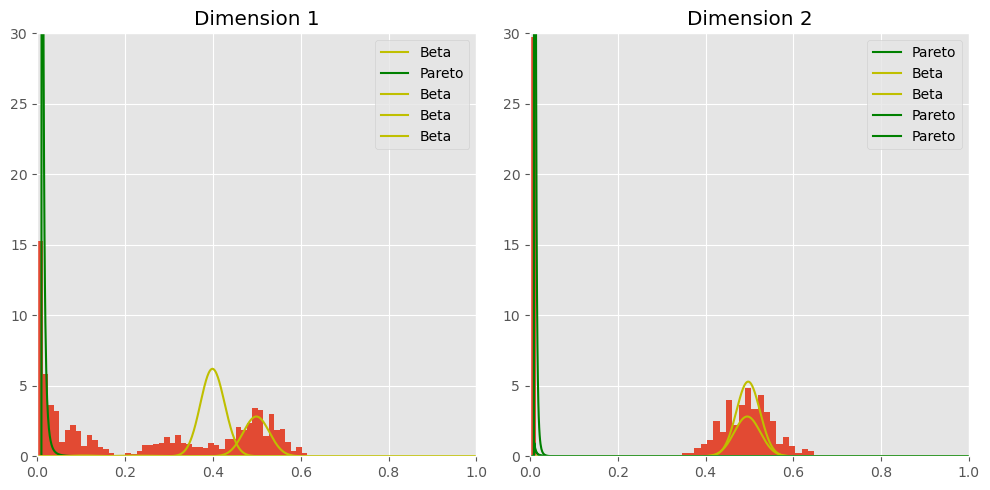

Alpha:  tensor([[1.8893, 5.3554],
        [3.2486, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.3567],
        [3.2494, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.3580],
        [3.2505, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.3593],
        [3.2513, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.3605],
        [3.2523, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.3618],
        [3.2532, 2.0000],
        [1.9998, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.889

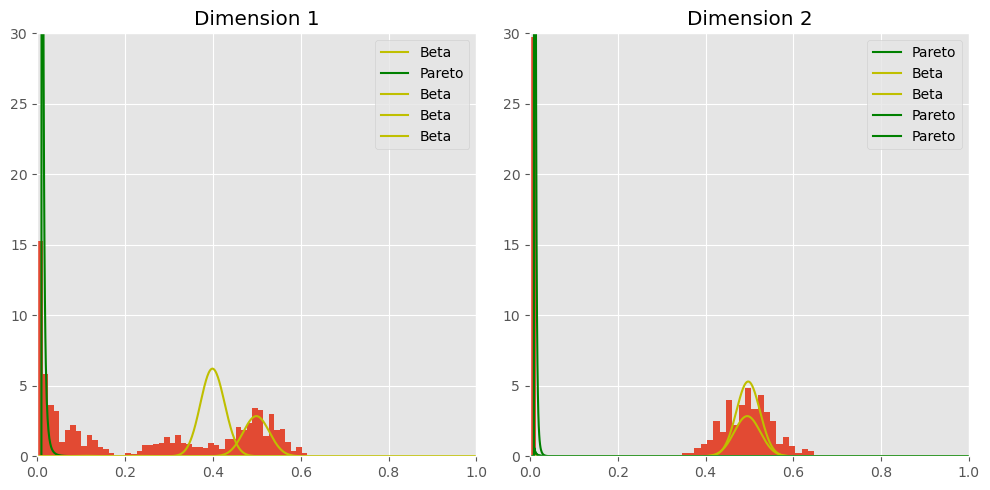

Alpha:  tensor([[1.8893, 5.8585],
        [3.6479, 1.9992],
        [1.9988, 1.9995],
        [2.0000, 2.0000],
        [1.9997, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.8597],
        [3.6490, 2.0008],
        [2.0006, 2.0004],
        [2.0001, 2.0000],
        [2.0001, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.8610],
        [3.6502, 1.9994],
        [1.9994, 1.9998],
        [1.9999, 2.0000],
        [2.0001, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.8622],
        [3.6514, 2.0003],
        [1.9998, 2.0000],
        [2.0001, 2.0000],
        [1.9998, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.8634],
        [3.6525, 2.0000],
        [2.0002, 2.0001],
        [2.0000, 2.0000],
        [2.0003, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 5.8647],
        [3.6537, 1.9997],
        [1.9992, 1.9997],
        [2.0000, 2.0000],
        [1.9997, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.889

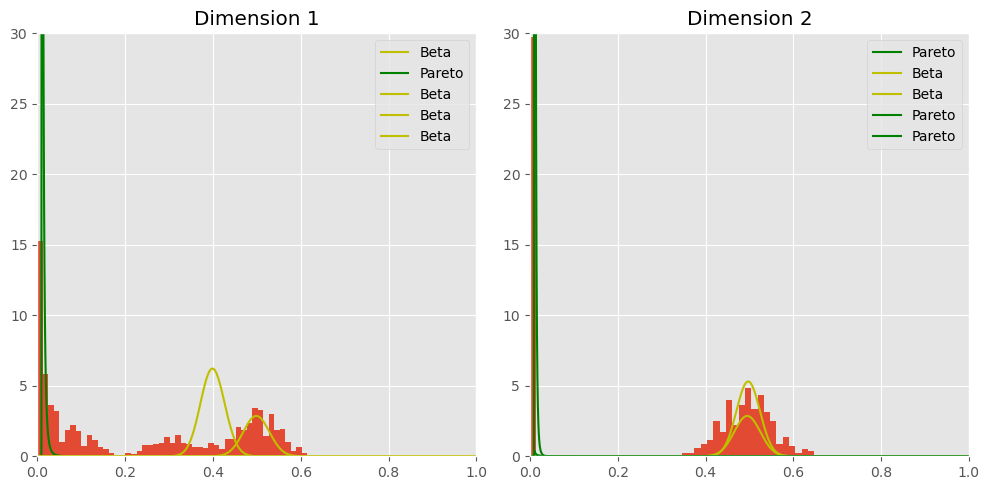

Alpha:  tensor([[1.8884, 6.3497],
        [4.1530, 2.0003],
        [1.9998, 2.0003],
        [2.0007, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8903, 6.3509],
        [4.1546, 1.9997],
        [1.9999, 1.9996],
        [1.9992, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8882, 6.3521],
        [4.1562, 2.0004],
        [1.9999, 2.0004],
        [2.0009, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8904, 6.3534],
        [4.1578, 1.9994],
        [1.9998, 1.9995],
        [1.9990, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8883, 6.3546],
        [4.1594, 2.0007],
        [1.9999, 2.0007],
        [2.0010, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8900, 6.3558],
        [4.1611, 1.9991],
        [1.9998, 1.9992],
        [1.9990, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.888

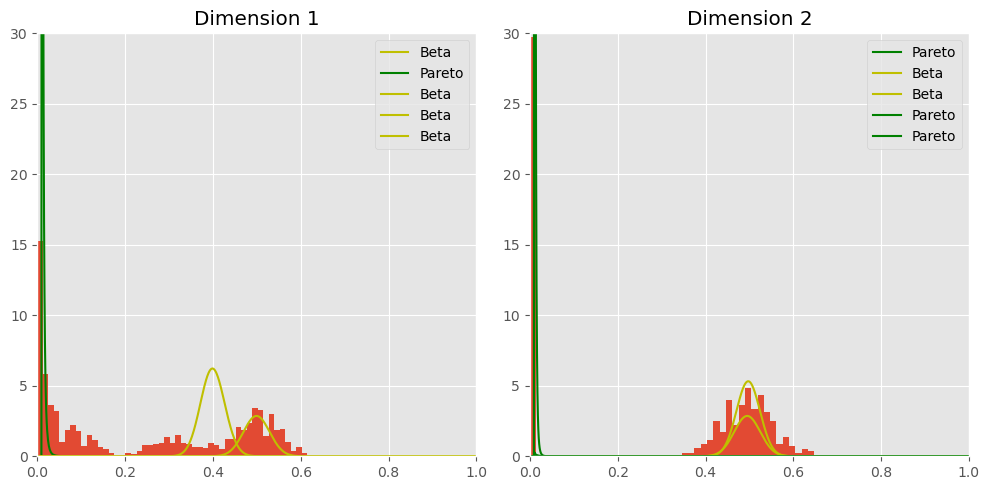

Alpha:  tensor([[1.8893, 6.8344],
        [4.7034, 1.9996],
        [2.0000, 2.0000],
        [2.0000, 2.0000],
        [1.9997, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 6.8356],
        [4.7047, 2.0004],
        [2.0000, 2.0000],
        [2.0000, 2.0000],
        [2.0003, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 6.8368],
        [4.7059, 1.9997],
        [1.9999, 2.0000],
        [2.0000, 2.0000],
        [1.9997, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 6.8380],
        [4.7072, 2.0002],
        [2.0001, 2.0000],
        [2.0000, 2.0000],
        [2.0002, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 6.8392],
        [4.7085, 1.9999],
        [1.9999, 2.0000],
        [2.0000, 2.0000],
        [1.9999, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.8893, 6.8404],
        [4.7097, 1.9999],
        [2.0000, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.889

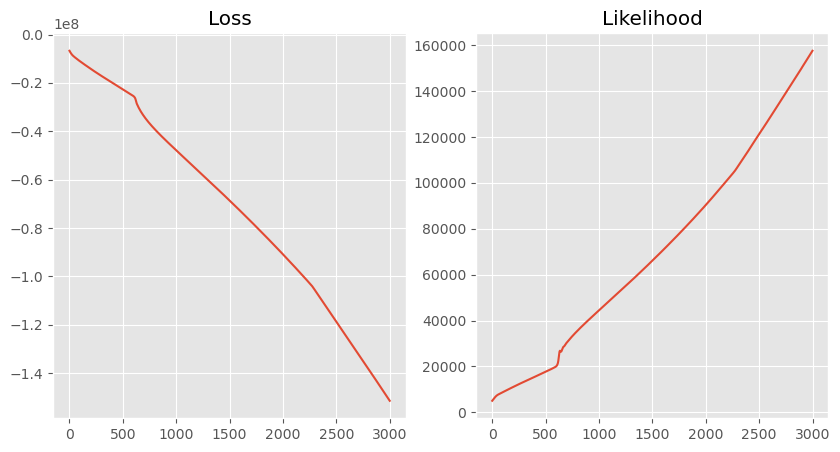

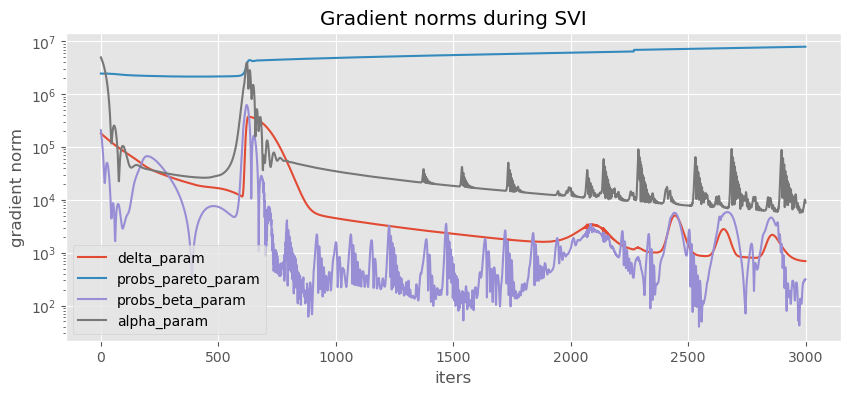

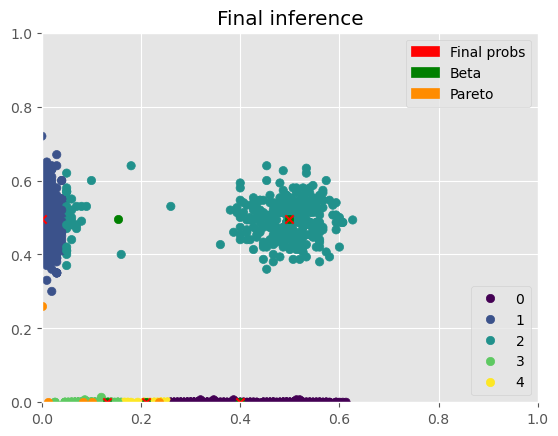

In [116]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

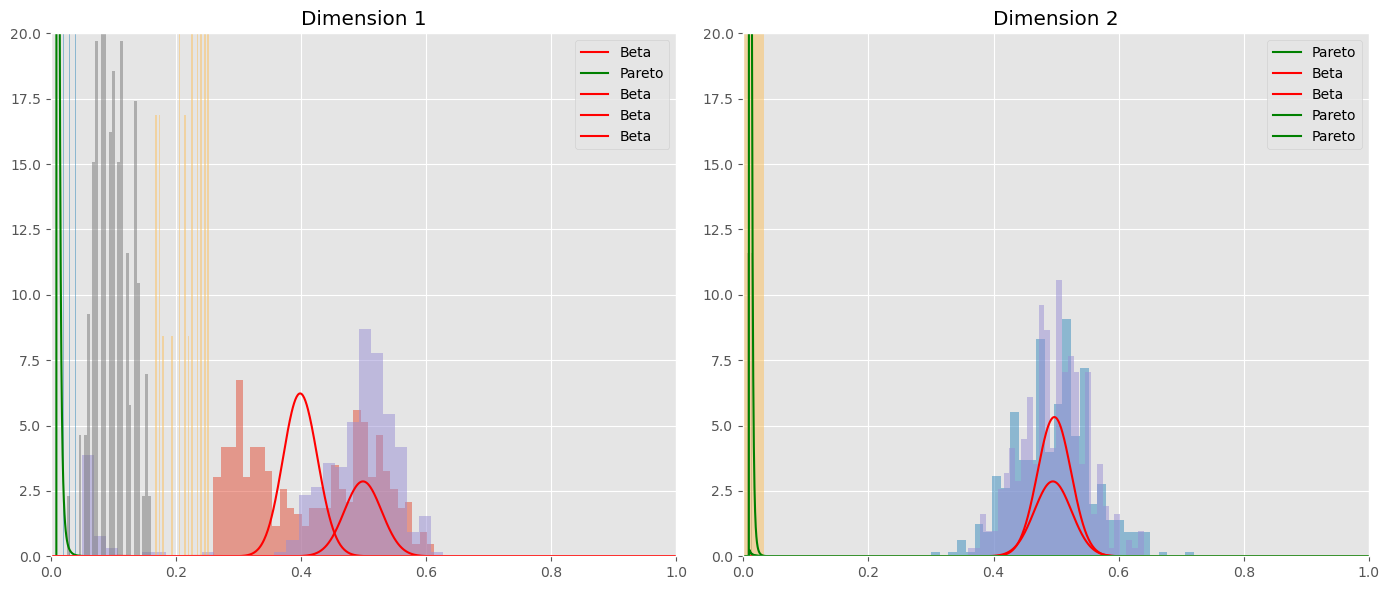

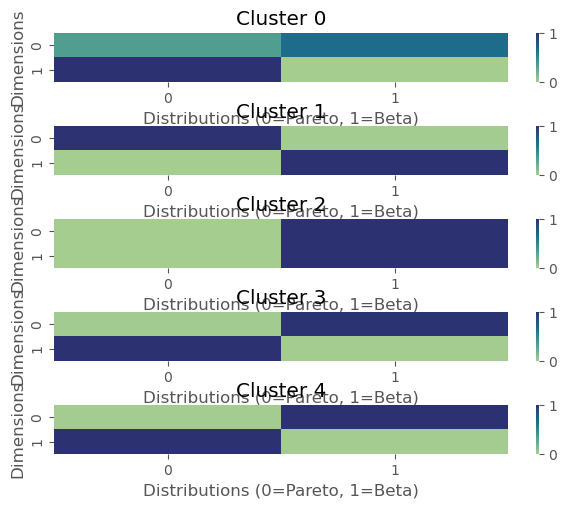

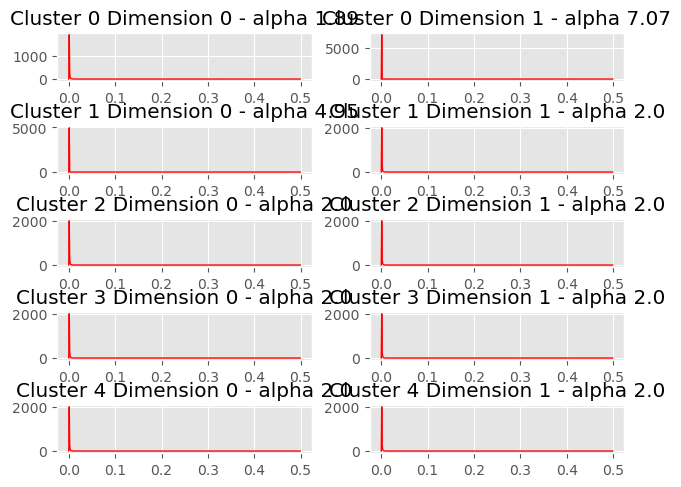

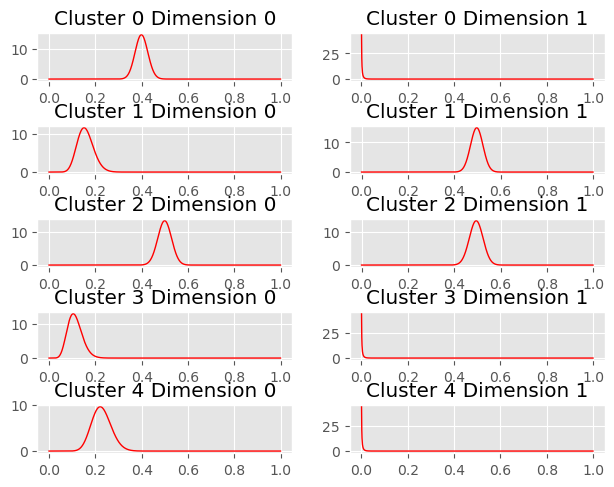

In [117]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [118]:
mb.params

{'probs_beta': tensor([[3.9890e-01, 2.3418e-11],
         [1.5437e-01, 4.9719e-01],
         [4.9903e-01, 4.9486e-01],
         [1.3230e-01, 3.4335e-11],
         [2.0934e-01, 3.3962e-11]]),
 'probs_pareto': tensor([[8.2526e-02, 3.6994e-13],
         [5.0154e-10, 2.6144e-01],
         [2.3520e-01, 2.2188e-04],
         [1.2527e-02, 4.0558e-06],
         [1.0190e-01, 4.7591e-06]]),
 'weights': tensor([0.4280, 0.3568, 0.2129, 0.0010, 0.0012]),
 'delta': tensor([[[3.3338e-01, 6.6662e-01],
          [9.9983e-01, 1.6599e-04]],
 
         [[9.8995e-01, 1.0052e-02],
          [4.5274e-04, 9.9955e-01]],
 
         [[6.3447e-04, 9.9937e-01],
          [4.5327e-04, 9.9955e-01]],
 
         [[1.2627e-02, 9.8737e-01],
          [9.9356e-01, 6.4428e-03]],
 
         [[7.0619e-03, 9.9294e-01],
          [9.9298e-01, 7.0154e-03]]]),
 'alpha_pareto': tensor([[1.8893, 7.0738],
         [4.9473, 2.0000],
         [2.0000, 1.9994],
         [1.9997, 2.0000],
         [2.0000, 2.0000]]),
 'phi_beta': tens

### With 3 beta components

In [119]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.1, k_beta_x = 250, phi_beta_y = 0.1, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [120]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

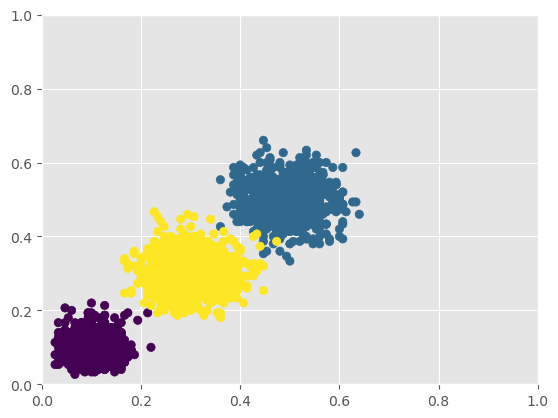

In [121]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

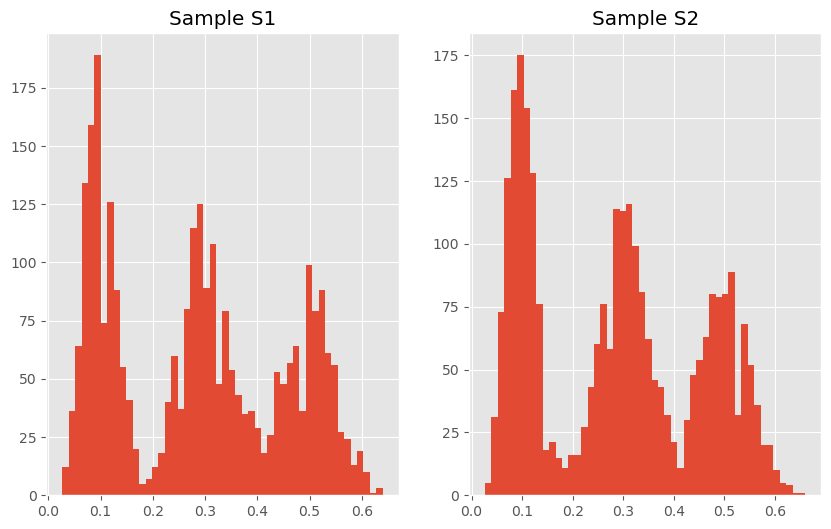

In [122]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[0.4994, 0.4985],
        [0.3003, 0.3027],
        [0.0985, 0.0993]])
Beta:  tensor([[0.5292, 0.5293],
        [0.6039, 0.6020],
        [0.9391, 0.9365]])
Pareto:  tensor([[-6.4340, -6.4288],
        [-4.9086, -4.9326],
        [-1.5647, -1.5898]])
Alpha:  tensor([[2., 2.],
        [2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9980, 1.9980],
        [1.9980, 1.9980],
        [1.9980, 1.9980]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 52046912.0
weights_param tensor([0.5653, 0.1824, 0.2524], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9993, 1.9993],
        [1.9983, 1.9983],
        [1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4994, 0.4985],
        [0.3006, 0.3030],
        [0.0987, 0.0995]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0100, 5.0100],
        [5.0100, 5.0100],
        [5.0100, 5.0100]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.4994, 0.4985],
        [0.3001, 0.3025],
      

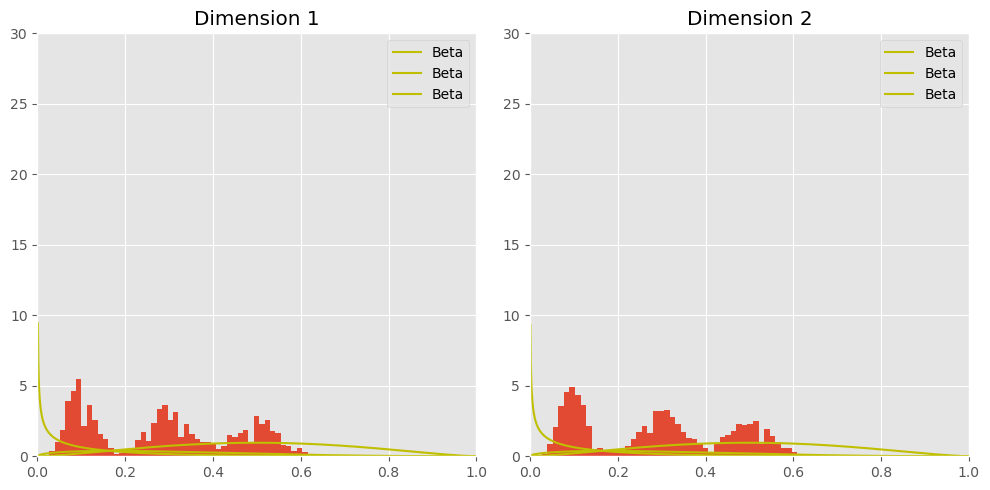

Alpha:  tensor([[1.9993, 1.9993],
        [1.9983, 1.9983],
        [1.9960, 1.9960]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0006, 2.0006],
        [1.9991, 1.9992],
        [1.9941, 1.9941]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0011, 2.0011],
        [1.9998, 1.9998],
        [1.9922, 1.9922]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0009, 2.0009],
        [1.9999, 1.9999],
        [1.9905, 1.9905]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0003, 2.0003],
        [1.9995, 1.9995],
        [1.9888, 1.9889]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9996, 1.9996],
        [1.9990, 1.9990],
        [1.9874, 1.9875]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9990, 1.9990],
        [1.9986, 1.9986],
        [1.9862, 1.9863]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9988, 1.9988],
        [1.9985, 1.9985],
        [1.9853, 1.9855]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9990, 1.9990],
        [1.9987, 1.9987],
        [1.9847, 1.9849]], grad_fn=<AddBackward0>)
A

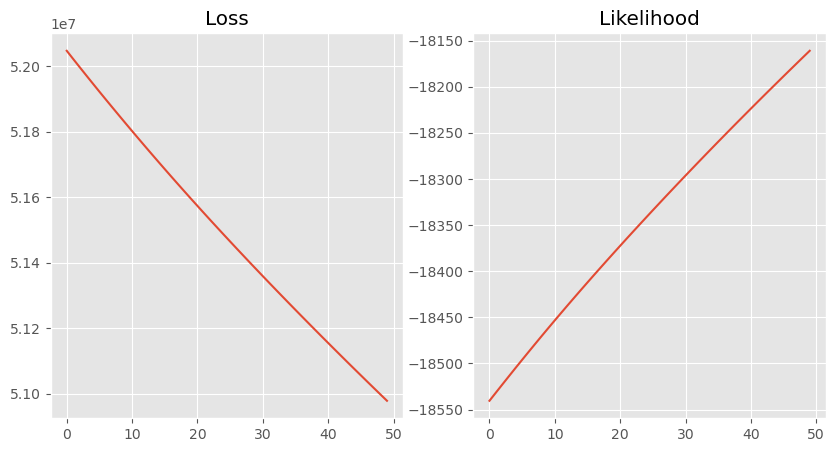

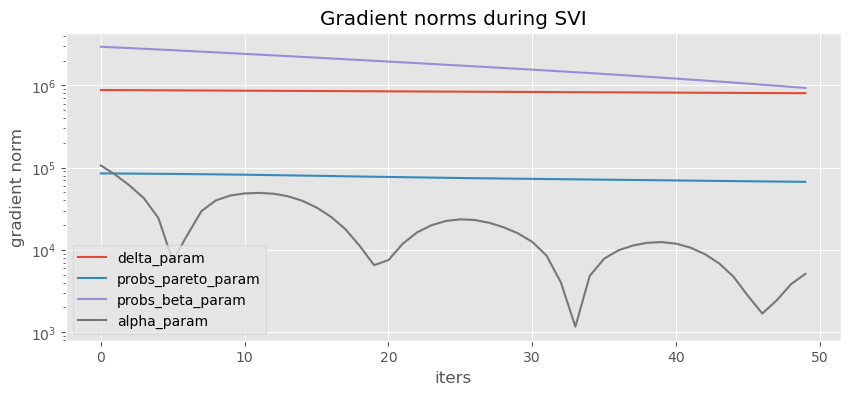

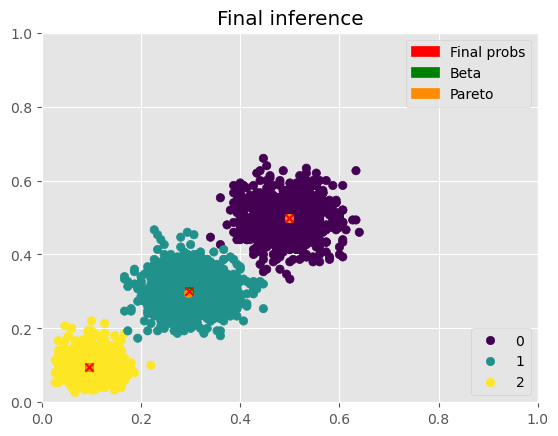

In [123]:
mb = mobster_MV(NV, DP, K = 3, seed = 821)
mb.fit(num_iter = 3000, lr = 0.001)

In [124]:
mb.params

{'probs_beta': tensor([[0.4989, 0.4981],
         [0.2973, 0.2998],
         [0.0950, 0.0959]]),
 'probs_pareto': tensor([[0.4988, 0.4979],
         [0.2942, 0.2967],
         [0.0947, 0.0955]]),
 'weights': tensor([0.5414, 0.1924, 0.2662]),
 'delta': tensor([[[0.0913, 0.9087],
          [0.0913, 0.9087]],
 
         [[0.0913, 0.9087],
          [0.0913, 0.9087]],
 
         [[0.0913, 0.9087],
          [0.0913, 0.9087]]]),
 'alpha_pareto': tensor([[1.9997, 1.9997],
         [1.9991, 1.9991],
         [1.9901, 1.9903]]),
 'phi_beta': tensor([[0.4991, 0.4985],
         [0.3063, 0.3087],
         [0.1026, 0.1034]]),
 'k_beta': tensor([[5.2615, 5.2615],
         [5.2613, 5.2613],
         [5.2611, 5.2611]]),
 'responsib': tensor([[0.0000e+00, 3.7835e-44, 0.0000e+00,  ..., 2.3417e-16, 8.1565e-11,
          2.2838e-12],
         [3.1944e-15, 2.0847e-13, 1.1204e-20,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 7.0281e-13, 5.8012e-22

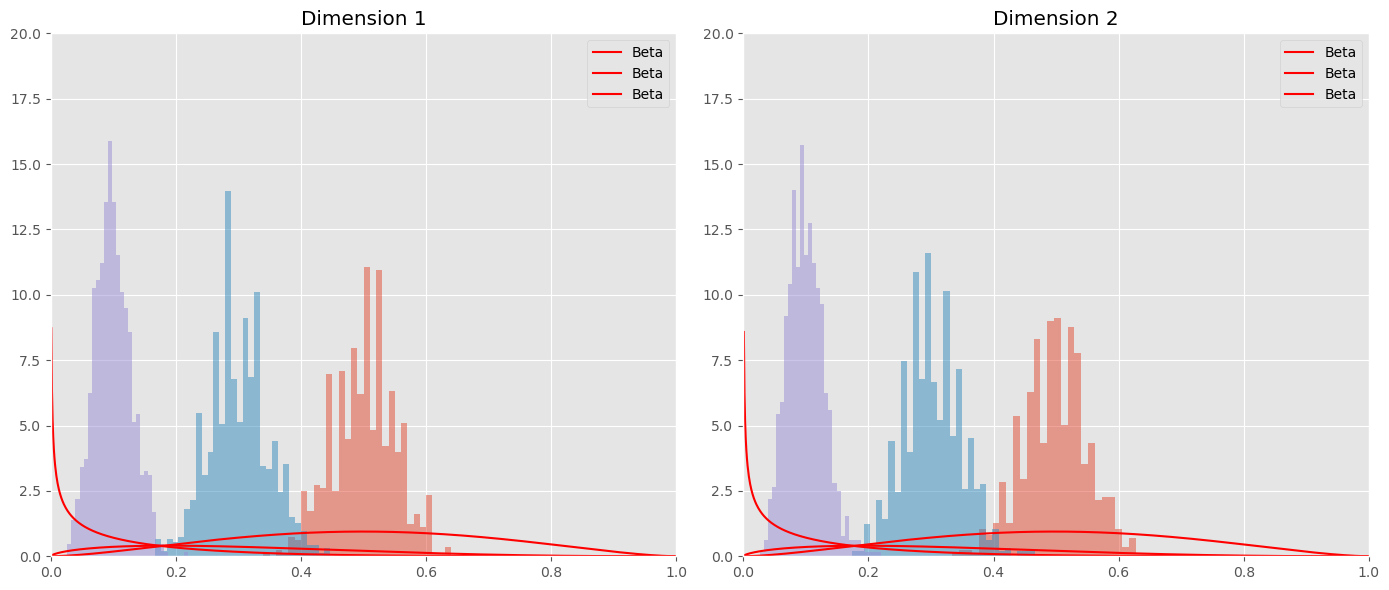

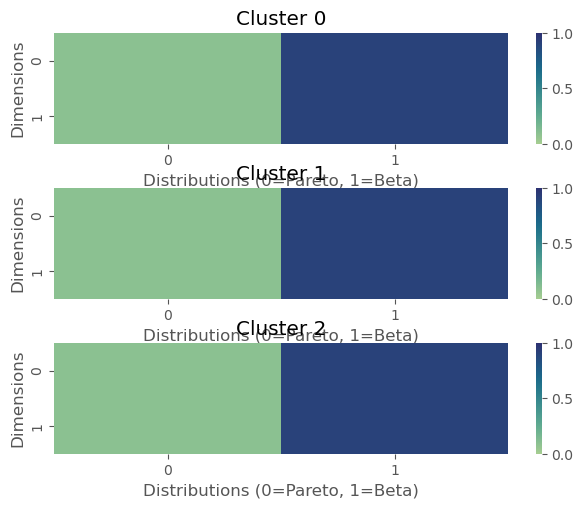

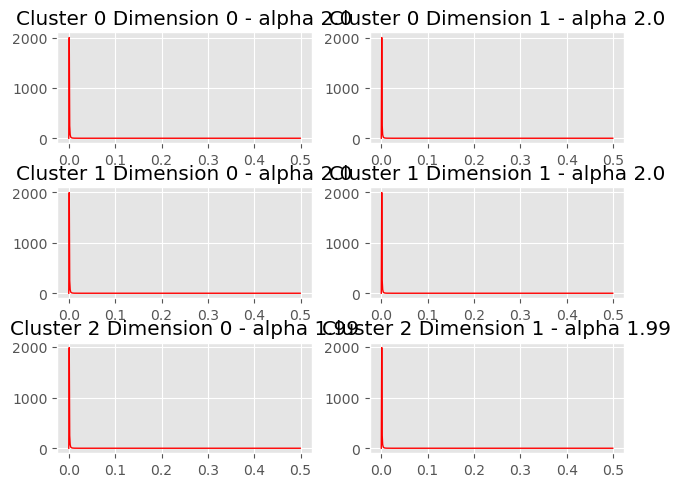

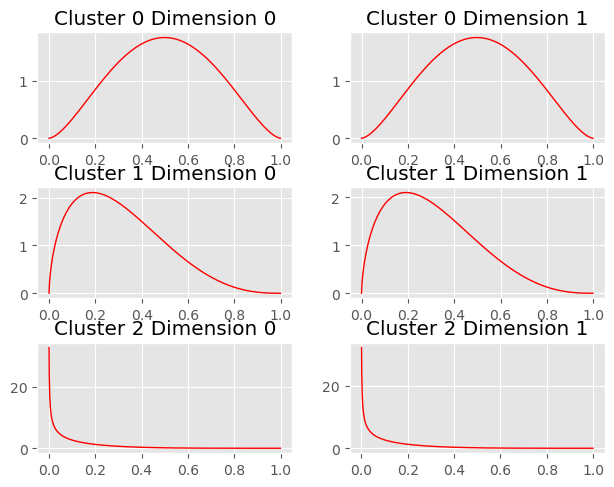

In [125]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### With 3 beta components (1 private)

In [126]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.4, k_beta_x = 250, phi_beta_y = 0.0001, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [127]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

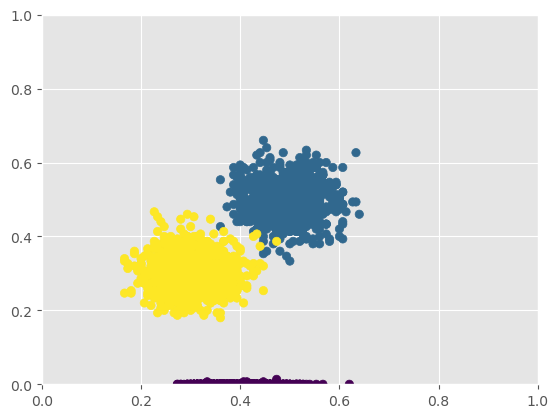

In [128]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

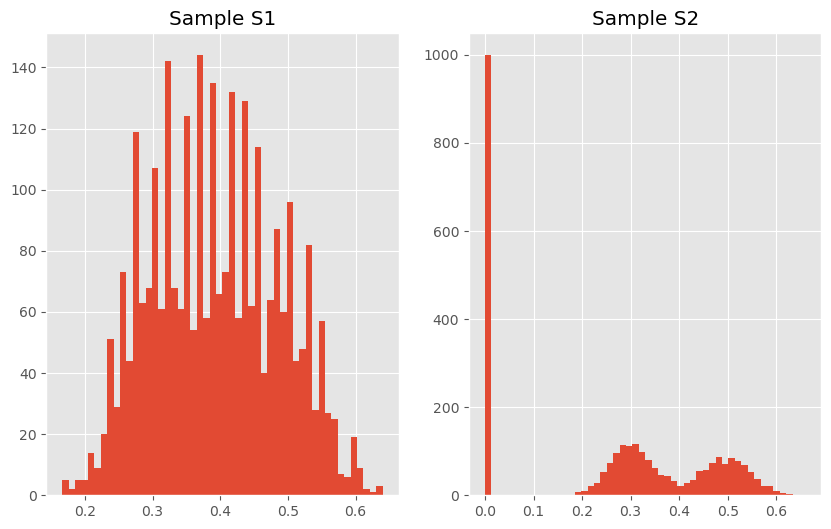

In [129]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[4.0035e-01, 3.9876e-05],
        [4.9931e-01, 4.9832e-01],
        [3.0027e-01, 3.0281e-01]])
Beta:  tensor([[0.5468, 1.6077],
        [0.5292, 0.5293],
        [0.6040, 0.6019]])
Pareto:  tensor([[-5.7710, 21.8721],
        [-6.4336, -6.4277],
        [-4.9080, -4.9332]])
Alpha:  tensor([[2., 2.],
        [2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9980, 2.0020],
        [1.9980, 1.9980],
        [1.9980, 1.9980]], grad_fn=<AddBackward0>)
Iteration 0: Loss = -13452410.0
weights_param tensor([0.3689, 0.3738, 0.2573], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9991, 2.0040],
        [1.9993, 1.9993],
        [1.9983, 1.9983]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.0053e-01, 3.9955e-05],
        [4.9933e-01, 4.9835e-01],
        [3.0052e-01, 3.0305e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0100, 5.0100],
        [5.0100, 5.0100],
        [5.0100, 5.0100]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[

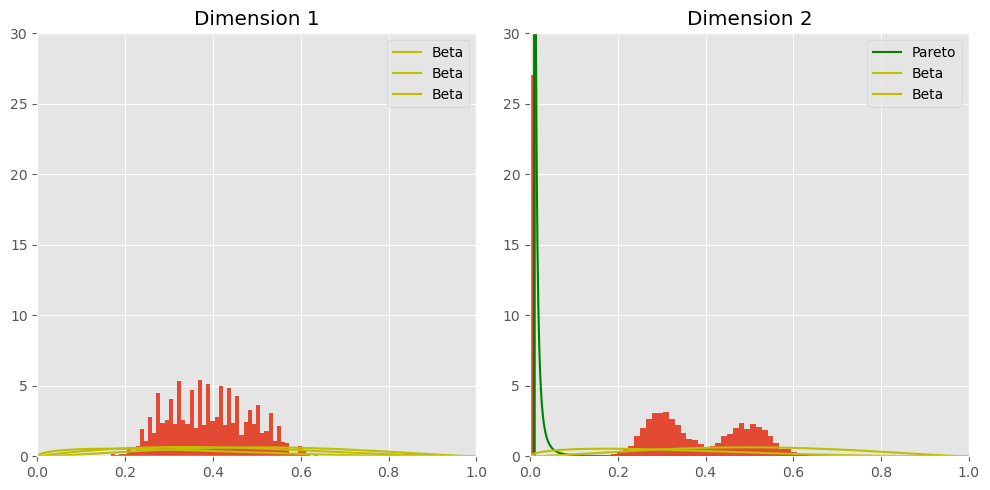

Alpha:  tensor([[1.9991, 2.0040],
        [1.9993, 1.9993],
        [1.9983, 1.9983]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0002, 2.0060],
        [2.0006, 2.0006],
        [1.9991, 1.9992]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0007, 2.0080],
        [2.0011, 2.0011],
        [1.9998, 1.9998]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0004, 2.0100],
        [2.0009, 2.0009],
        [1.9999, 1.9999]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9998, 2.0120],
        [2.0003, 2.0003],
        [1.9995, 1.9995]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9992, 2.0141],
        [1.9996, 1.9996],
        [1.9990, 1.9990]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9988, 2.0161],
        [1.9990, 1.9990],
        [1.9986, 1.9986]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9988, 2.0181],
        [1.9988, 1.9988],
        [1.9985, 1.9985]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9990, 2.0201],
        [1.9990, 1.9990],
        [1.9987, 1.9987]], grad_fn=<AddBackward0>)
A

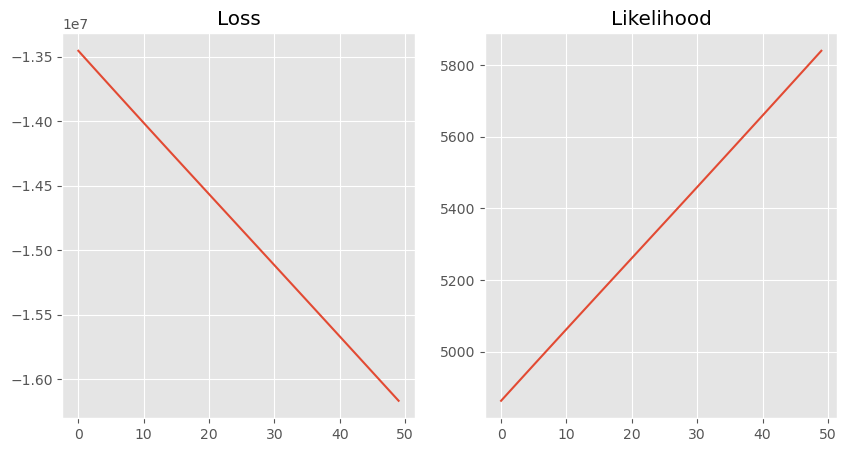

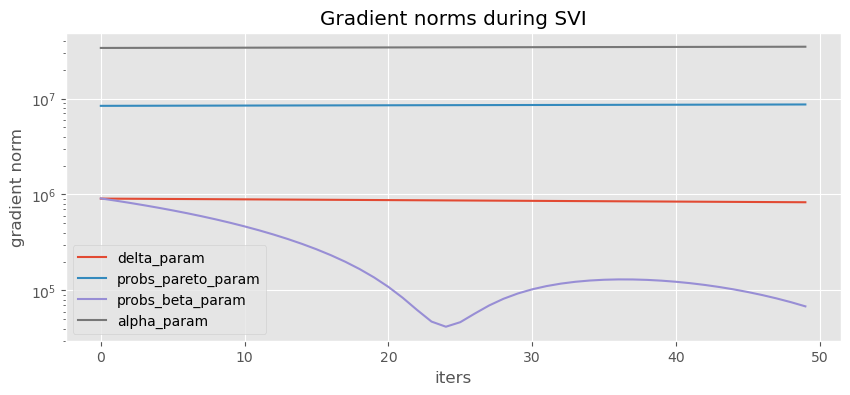

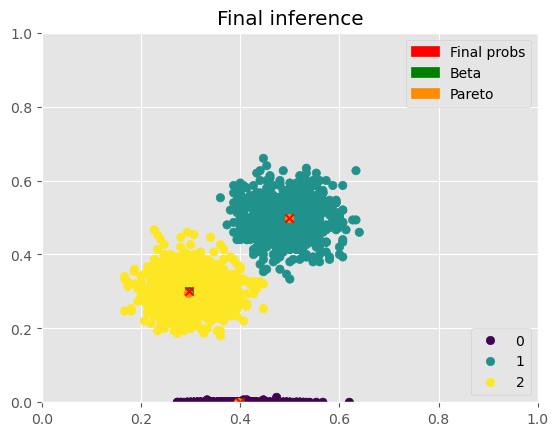

In [130]:
mb = mobster_MV(NV, DP, K = 3, seed = 48)
mb.fit(num_iter = 3000, lr = 0.001)

In [131]:
mb.params

{'probs_beta': tensor([[3.9926e-01, 3.7892e-05],
         [4.9910e-01, 4.9822e-01],
         [2.9768e-01, 3.0014e-01]]),
 'probs_pareto': tensor([[3.9594e-01, 3.7885e-05],
         [4.9877e-01, 4.9773e-01],
         [2.9413e-01, 2.9670e-01]]),
 'weights': tensor([0.3610, 0.3635, 0.2754]),
 'delta': tensor([[[0.0913, 0.9087],
          [0.9087, 0.0913]],
 
         [[0.0913, 0.9087],
          [0.0913, 0.9087]],
 
         [[0.0913, 0.9087],
          [0.0913, 0.9087]]]),
 'alpha_pareto': tensor([[1.9997, 2.1050],
         [1.9997, 1.9997],
         [1.9991, 1.9991]]),
 'phi_beta': tensor([[4.0447e-01, 4.1962e-05],
         [4.9922e-01, 4.9854e-01],
         [3.0630e-01, 3.0880e-01]]),
 'k_beta': tensor([[5.2614, 5.2632],
         [5.2615, 5.2615],
         [5.2613, 5.2613]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0749e-16, 3.6859e-11,
          1.0362e-12],
  

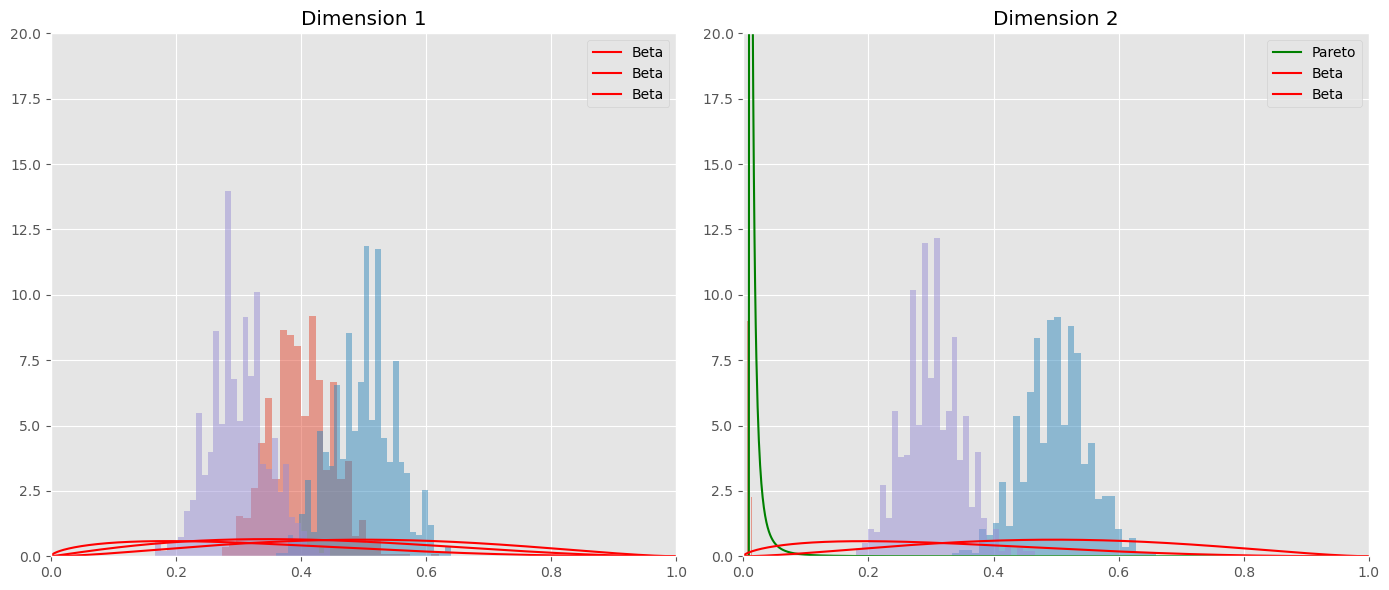

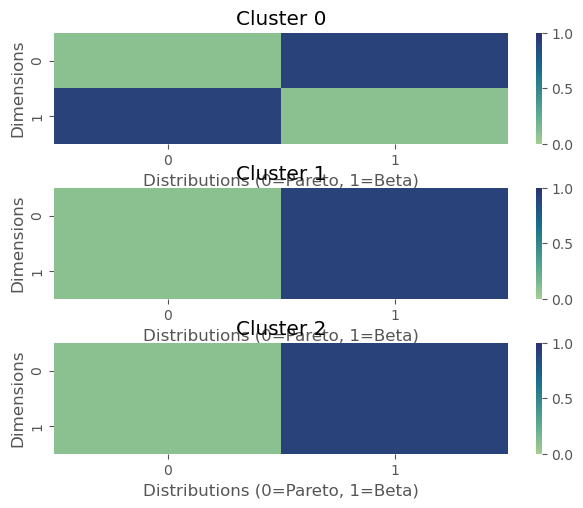

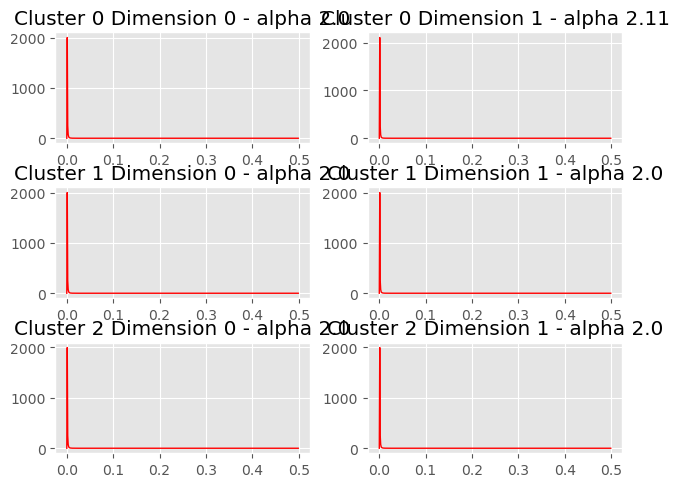

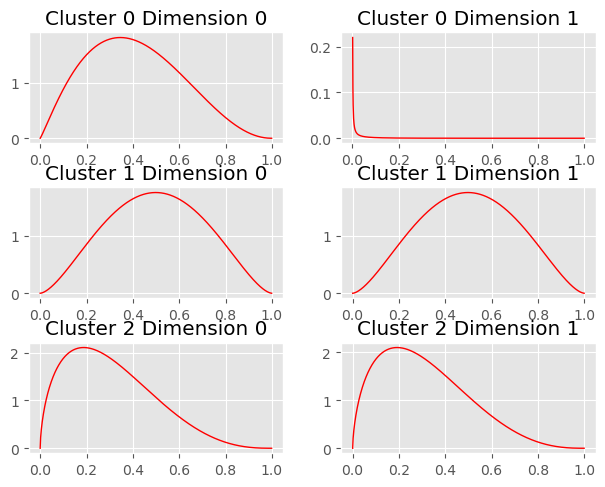

In [132]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)